# Soil Moisture Correlation Analysis

This notebook analyzes the correlation between satellite-derived variables and field-measured soil moisture using different temporal approaches:

## Methodology:
1. **Data Integration**: Merge satellite band extractions with field soil moisture measurements
2. **Temporal Scenarios**: 
   - **Same-Date Only**: Correlations using only same-date satellite images (median if multiple)
   - **Multi-Temporal Median**: Correlations using median of same/before/after images per point
3. **Variable Analysis**: Test correlations for all satellite bands and derived indices
4. **Visualization**: Comparative correlation plot showing both temporal approaches

## Expected Output:
- Correlation coefficients for each satellite variable vs soil moisture
- Comparative visualization showing temporal approach effectiveness
- Statistical analysis to guide next steps

## 1. Setup and Data Loading

In [183]:
# Import required libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")
print("✓ Plot settings configured")
print("✓ Ready for soil moisture correlation analysis!")

✓ Libraries imported successfully
✓ Plot settings configured
✓ Ready for soil moisture correlation analysis!


## 2. Load Satellite Data and Soil Moisture Measurements

In [184]:
# Load satellite band extraction results
satellite_file = "multi_temporal_satellite_bands.csv"
if not Path(satellite_file).exists():
    print(f"⚠ {satellite_file} not found!")
    print("Please run the multi-temporal band extraction notebook first.")
else:
    satellite_df = pd.read_csv(satellite_file)
    print(f"✓ Satellite data loaded: {satellite_df.shape}")
    print(f"  Columns: {list(satellite_df.columns)}")
    print(f"  Sensors: {satellite_df['sensor'].value_counts().to_dict()}")
    print(f"  Temporal slots: {satellite_df['slot'].value_counts().to_dict()}")

# Load soil moisture field measurements from shapefile
shapefile_path = "soil_moisture_sample_points_7sep.shp"
if not Path(shapefile_path).exists():
    print(f"⚠ {shapefile_path} not found!")
else:
    soil_moisture_gdf = gpd.read_file(shapefile_path)
    print(f"\n✓ Soil moisture data loaded: {soil_moisture_gdf.shape}")
    print(f"  Columns: {list(soil_moisture_gdf.columns)}")
    
    # Show soil moisture statistics
    if 'VWC' in soil_moisture_gdf.columns:
        soil_stats = soil_moisture_gdf['VWC'].describe()
        print(f"\n=== SOIL MOISTURE STATISTICS (VWC) ===")
        print(f"  Count: {soil_stats['count']:.0f} measurements")
        print(f"  Range: {soil_stats['min']:.2f} - {soil_stats['max']:.2f}")
        print(f"  Mean: {soil_stats['mean']:.2f} ± {soil_stats['std']:.2f}")
    else:
        print(f"  Available soil moisture columns: {[col for col in soil_moisture_gdf.columns if 'moisture' in col.lower() or 'vwc' in col.lower()]}")

✓ Satellite data loaded: (76, 19)
  Columns: ['point_id', 'point_date', 'slot', 'sensor', 'acquisition_date', 'longitude', 'latitude', 'image_id', 's2_B2', 's2_B3', 's2_B4', 's2_B8', 's2_B11', 's2_B12', 's1_VV', 's1_VH', 's1_angle', 's1_orbit_direction', 's1_relative_orbit']
  Sensors: {'S1': 56, 'S2': 20}
  Temporal slots: {'same': 33, 'previous': 23, 'next': 20}

✓ Soil moisture data loaded: (23, 8)
  Columns: ['fid_1', 'N', 'S', 'W', 'E', 'C', 'Date', 'geometry']
  Available soil moisture columns: []


## 3. Data Integration and Preparation

In [185]:
# Merge satellite data with soil moisture measurements
print("=== MERGING SATELLITE AND SOIL MOISTURE DATA ===")

# Initialize merged_df as empty DataFrame to avoid NameError
merged_df = pd.DataFrame()

# Check if satellite data was loaded successfully
if 'satellite_df' not in globals():
    print("⚠ Satellite data not loaded. Please run cell 2 first.")
elif 'soil_moisture_gdf' not in globals():
    print("⚠ Soil moisture data not loaded. Please run cell 2 first.")
else:
    print("=== PROCESSING SOIL MOISTURE MEASUREMENTS ===")
    print("Detected 5 measurements per point: C (center), N (north), S (south), W (west), E (east)")
    
    # Calculate median soil moisture per point from the 5 directional measurements
    soil_measurements = ['C', 'N', 'S', 'W', 'E']
    available_measurements = [col for col in soil_measurements if col in soil_moisture_gdf.columns]
    
    print(f"Available measurement columns: {available_measurements}")
    
    if len(available_measurements) < 2:
        print("⚠ Need at least 2 directional measurements to calculate median")
        soil_data = None
    else:
        # Create soil moisture dataset with median per point
        soil_data = soil_moisture_gdf[['fid_1'] + available_measurements].copy()
        
        # Calculate median across directional measurements
        soil_data['soil_moisture_median'] = soil_data[available_measurements].median(axis=1)
        
        # Show statistics of individual measurements vs median
        print(f"\n=== SOIL MOISTURE MEASUREMENT STATISTICS ===")
        for col in available_measurements:
            stats = soil_data[col].describe()
            print(f"{col} direction: Mean={stats['mean']:.2f}, Std={stats['std']:.2f}, Range=[{stats['min']:.2f}, {stats['max']:.2f}]")
        
        median_stats = soil_data['soil_moisture_median'].describe()
        print(f"MEDIAN values: Mean={median_stats['mean']:.2f}, Std={median_stats['std']:.2f}, Range=[{median_stats['min']:.2f}, {median_stats['max']:.2f}]")
        
        # Check variability within points (coefficient of variation)
        soil_data['cv'] = soil_data[available_measurements].std(axis=1) / soil_data[available_measurements].mean(axis=1)
        print(f"\nVariability within points (Coefficient of Variation):")
        print(f"  Mean CV: {soil_data['cv'].mean():.3f}")
        print(f"  Max CV: {soil_data['cv'].max():.3f} (point {soil_data.loc[soil_data['cv'].idxmax(), 'fid_1']})")
        
        # Show sample of measurements and median
        print(f"\n=== SAMPLE MEASUREMENTS AND MEDIAN ===")
        sample_cols = ['fid_1'] + available_measurements + ['soil_moisture_median']
        print(soil_data[sample_cols].head(8).to_string(index=False, float_format='%.2f'))
        
        # Prepare final soil data for merging
        soil_data = soil_data[['fid_1', 'soil_moisture_median']].rename(columns={
            'fid_1': 'point_id', 
            'soil_moisture_median': 'soil_moisture'
        })
    
    # Merge datasets if soil_data was created successfully
    if soil_data is not None:
        merged_df = satellite_df.merge(soil_data, on='point_id', how='inner')
        print(f"\n✓ Data merged successfully: {merged_df.shape}")
        print(f"  Points with both satellite and soil data: {merged_df['point_id'].nunique()}")
        
        # Show sample of merged data
        print(f"\n=== SAMPLE MERGED DATA ===")
        sample_cols = ['point_id', 'sensor', 'slot', 'soil_moisture']
        if 's2_B2' in merged_df.columns:
            sample_cols.append('s2_B2')
        if 's1_VV' in merged_df.columns:
            sample_cols.append('s1_VV')
        
        print(merged_df[sample_cols].head(10).to_string(index=False, float_format='%.3f'))
        
        # Check for missing values
        print(f"\n=== DATA COMPLETENESS CHECK ===")
        missing_soil = merged_df['soil_moisture'].isnull().sum()
        print(f"Missing soil moisture values: {missing_soil}")
        
        # Final soil moisture statistics in merged dataset
        soil_final_stats = merged_df['soil_moisture'].describe()
        print(f"\nFinal soil moisture statistics (median per point):")
        print(f"  Count: {soil_final_stats['count']:.0f} points")
        print(f"  Range: [{soil_final_stats['min']:.2f}, {soil_final_stats['max']:.2f}]")
        print(f"  Mean: {soil_final_stats['mean']:.2f} ± {soil_final_stats['std']:.2f}")
        
        # Check satellite band completeness
        band_columns = [col for col in merged_df.columns if col.startswith(('s1_', 's2_'))]
        print(f"\nSatellite band completeness (first 10 bands):")
        for col in band_columns[:10]:  # Show first 10 bands
            missing_count = merged_df[col].isnull().sum()
            total_count = len(merged_df)
            print(f"  {col}: {missing_count}/{total_count} missing ({missing_count/total_count*100:.1f}%)")
    else:
        print("⚠ Could not create soil moisture dataset. Please check column names.")

# Final check
if merged_df.empty:
    print("\n⚠ WARNING: merged_df is empty. Cannot proceed with analysis.")
    print("Please check the data loading and merging steps above.")
else:
    print(f"\n✓ Ready for analysis with {len(merged_df)} merged records")
    print(f"✓ Using MEDIAN of 5 directional measurements per point as soil moisture variable")

=== MERGING SATELLITE AND SOIL MOISTURE DATA ===
=== PROCESSING SOIL MOISTURE MEASUREMENTS ===
Detected 5 measurements per point: C (center), N (north), S (south), W (west), E (east)
Available measurement columns: ['C', 'N', 'S', 'W', 'E']

=== SOIL MOISTURE MEASUREMENT STATISTICS ===
C direction: Mean=34.74, Std=11.27, Range=[18.40, 57.00]
N direction: Mean=36.20, Std=15.95, Range=[20.30, 79.00]
S direction: Mean=34.68, Std=14.08, Range=[14.00, 68.00]
W direction: Mean=35.44, Std=12.71, Range=[13.00, 68.00]
E direction: Mean=35.01, Std=13.63, Range=[18.00, 73.00]
MEDIAN values: Mean=35.15, Std=11.29, Range=[18.00, 62.00]

Variability within points (Coefficient of Variation):
  Mean CV: 0.178
  Max CV: 0.461 (point 9.0)

=== SAMPLE MEASUREMENTS AND MEDIAN ===
 fid_1     C     N     S     W     E  soil_moisture_median
  0.00 54.00 54.00 33.00 36.00 19.00                 36.00
  1.00 57.00 49.00 27.00 52.00 52.00                 52.00
  2.00 52.00 65.00 59.00 52.00 73.00                 

## 4. Scenario 1: Same-Date Correlations

In [186]:
print("=== SCENARIO 1: SAME-DATE CORRELATIONS ===")
print("Using only same-date satellite images (median if multiple images per date)")

# Check if merged_df exists and is not empty
if 'merged_df' not in globals() or merged_df.empty:
    print("⚠ No merged data available. Please run the data integration step first.")
    same_date_aggregated = pd.DataFrame()  # Create empty DataFrame to avoid errors
else:
    # Filter for same-date data only
    same_date_df = merged_df[merged_df['slot'] == 'same'].copy()
    print(f"\n✓ Same-date records: {len(same_date_df)}")
    print(f"  Points covered: {same_date_df['point_id'].nunique()}")
    print(f"  Sensors: {same_date_df['sensor'].value_counts().to_dict()}")

    if len(same_date_df) == 0:
        print("⚠ No same-date records found in the data.")
        same_date_aggregated = pd.DataFrame()
    else:
        # Calculate median values per point and sensor (in case of multiple images per date)
        print("\n✓ Calculating median values per point and sensor...")

        # Identify satellite bands for aggregation
        satellite_bands = [col for col in same_date_df.columns if col.startswith(('s1_', 's2_'))]
        satellite_bands = [col for col in satellite_bands if col not in ['s1_orbit_direction', 's1_relative_orbit', 's1_angle']]  # Exclude metadata and angle

        print(f"  Satellite bands to aggregate: {len(satellite_bands)}")
        for band in satellite_bands[:10]:  # Show first 10
            print(f"    - {band}")
        if len(satellite_bands) > 10:
            print(f"    ... and {len(satellite_bands) - 10} more")

        # Group by point_id and sensor, calculate median
        agg_dict = {}
        for band in satellite_bands:
            agg_dict[band] = 'median'
        agg_dict['soil_moisture'] = 'first'  # Soil moisture is the same for all records of a point

        same_date_aggregated = same_date_df.groupby(['point_id', 'sensor']).agg(agg_dict).reset_index()
        print(f"\n✓ Aggregated data: {same_date_aggregated.shape}")
        print(f"  Points: {same_date_aggregated['point_id'].nunique()}")
        print(f"  Sensors: {same_date_aggregated['sensor'].value_counts().to_dict()}")

        # Show sample of aggregated data
        print(f"\n=== SAMPLE AGGREGATED DATA ===")
        sample_cols = ['point_id', 'sensor', 'soil_moisture']
        if 's2_B2' in same_date_aggregated.columns:
            sample_cols.append('s2_B2')
        if 's1_VV' in same_date_aggregated.columns:
            sample_cols.append('s1_VV')

        print(same_date_aggregated[sample_cols].head(10).to_string(index=False))

=== SCENARIO 1: SAME-DATE CORRELATIONS ===
Using only same-date satellite images (median if multiple images per date)

✓ Same-date records: 33
  Points covered: 23
  Sensors: {'S1': 23, 'S2': 10}

✓ Calculating median values per point and sensor...
  Satellite bands to aggregate: 8
    - s2_B2
    - s2_B3
    - s2_B4
    - s2_B8
    - s2_B11
    - s2_B12
    - s1_VV
    - s1_VH

✓ Aggregated data: (33, 11)
  Points: 23
  Sensors: {'S1': 23, 'S2': 10}

=== SAMPLE AGGREGATED DATA ===
 point_id sensor  soil_moisture  s2_B2      s1_VV
        0     S1           36.0    NaN  -6.788332
        0     S2           36.0  476.0        NaN
        1     S1           52.0    NaN -10.412637
        1     S2           52.0  442.0        NaN
        2     S1           59.0    NaN  -7.459873
        2     S2           59.0  406.0        NaN
        4     S1           25.0    NaN  -9.922096
        4     S2           25.0  632.0        NaN
        6     S1           62.0    NaN -12.036739
        6    

## 5. Scenario 2: Multi-Temporal Median Correlations

In [187]:
print("=== SCENARIO 2: MULTI-TEMPORAL MEDIAN CORRELATIONS ===")
print("Using median of same/before/after images per point")

# Check if merged_df exists and is not empty
if 'merged_df' not in globals() or merged_df.empty:
    print("⚠ No merged data available. Please run the data integration step first.")
    multi_temporal_aggregated = pd.DataFrame()  # Create empty DataFrame to avoid errors
else:
    # Use all temporal slots (same, previous, next)
    all_temporal_df = merged_df.copy()
    print(f"\n✓ All temporal records: {len(all_temporal_df)}")
    print(f"  Points covered: {all_temporal_df['point_id'].nunique()}")
    print(f"  Temporal slots: {all_temporal_df['slot'].value_counts().to_dict()}")
    print(f"  Sensors: {all_temporal_df['sensor'].value_counts().to_dict()}")

    # Calculate median across all temporal slots per point and sensor
    print("\n✓ Calculating multi-temporal median values per point and sensor...")

    # Use the same aggregation dictionary from the previous cell
    if 'agg_dict' not in globals():
        # Recreate agg_dict if it doesn't exist
        satellite_bands = [col for col in all_temporal_df.columns if col.startswith(('s1_', 's2_'))]
        satellite_bands = [col for col in satellite_bands if col not in ['s1_orbit_direction', 's1_relative_orbit', 's1_angle']]
        agg_dict = {}
        for band in satellite_bands:
            agg_dict[band] = 'median'
        agg_dict['soil_moisture'] = 'first'

    # Group by point_id and sensor, calculate median across all temporal slots
    multi_temporal_aggregated = all_temporal_df.groupby(['point_id', 'sensor']).agg(agg_dict).reset_index()
    print(f"\n✓ Multi-temporal aggregated data: {multi_temporal_aggregated.shape}")
    print(f"  Points: {multi_temporal_aggregated['point_id'].nunique()}")
    print(f"  Sensors: {multi_temporal_aggregated['sensor'].value_counts().to_dict()}")

    # Show temporal coverage analysis
    print(f"\n=== TEMPORAL COVERAGE ANALYSIS ===")
    temporal_coverage = all_temporal_df.groupby(['point_id', 'sensor'])['slot'].nunique().reset_index()
    temporal_coverage_summary = temporal_coverage['slot'].value_counts().sort_index()
    print("Number of temporal slots per point-sensor combination:")
    for slots, count in temporal_coverage_summary.items():
        print(f"  {slots} slot(s): {count} point-sensor combinations")

    # Show sample of multi-temporal aggregated data
    print(f"\n=== SAMPLE MULTI-TEMPORAL AGGREGATED DATA ===")
    sample_cols = ['point_id', 'sensor', 'soil_moisture']
    if 's2_B2' in multi_temporal_aggregated.columns:
        sample_cols.append('s2_B2')
    if 's1_VV' in multi_temporal_aggregated.columns:
        sample_cols.append('s1_VV')
    
    print(multi_temporal_aggregated[sample_cols].head(10).to_string(index=False))

=== SCENARIO 2: MULTI-TEMPORAL MEDIAN CORRELATIONS ===
Using median of same/before/after images per point

✓ All temporal records: 76
  Points covered: 23
  Temporal slots: {'same': 33, 'previous': 23, 'next': 20}
  Sensors: {'S1': 56, 'S2': 20}

✓ Calculating multi-temporal median values per point and sensor...

✓ Multi-temporal aggregated data: (33, 11)
  Points: 23
  Sensors: {'S1': 23, 'S2': 10}

=== TEMPORAL COVERAGE ANALYSIS ===
Number of temporal slots per point-sensor combination:
  2 slot(s): 23 point-sensor combinations
  3 slot(s): 10 point-sensor combinations

=== SAMPLE MULTI-TEMPORAL AGGREGATED DATA ===
 point_id sensor  soil_moisture  s2_B2      s1_VV
        0     S1           36.0    NaN  -9.150972
        0     S2           36.0  674.0        NaN
        1     S1           52.0    NaN -11.666594
        1     S2           52.0  468.0        NaN
        2     S1           59.0    NaN  -8.874450
        2     S2           59.0  421.0        NaN
        4     S1         

## 6. Calculate Correlations for Both Scenarios

In [188]:
def calculate_correlations(df, scenario_name, include_indices=True):
    """
    Calculate Pearson correlations between satellite bands/indices and soil moisture
    """
    print(f"\n=== CALCULATING CORRELATIONS: {scenario_name} ===")
    
    correlations = []
    
    # Process each sensor separately
    for sensor in df['sensor'].unique():
        sensor_df = df[df['sensor'] == sensor].copy()
        print(f"\n{sensor} Sensor ({len(sensor_df)} points):")
        
        # Get satellite bands for this sensor
        sensor_bands = [col for col in sensor_df.columns if col.startswith(f'{sensor.lower()}_')]
        sensor_bands = [col for col in sensor_bands if col not in [f'{sensor.lower()}_orbit_direction', f'{sensor.lower()}_relative_orbit', f'{sensor.lower()}_angle']]
        
        for band in sensor_bands:
            # Remove rows with missing values for this band or soil moisture
            valid_data = sensor_df[[band, 'soil_moisture']].dropna()
            
            if len(valid_data) < 3:  # Need at least 3 points for correlation
                print(f"  {band}: Insufficient data ({len(valid_data)} points)")
                continue
            
            # Calculate Pearson correlation
            try:
                corr_coef, p_value = pearsonr(valid_data[band], valid_data['soil_moisture'])
                
                correlations.append({
                    'scenario': scenario_name,
                    'sensor': sensor,
                    'band': band,
                    'variable': f"{sensor}_{band.split('_', 1)[1]}",  # Clean variable name
                    'correlation': corr_coef,
                    'p_value': p_value,
                    'n_points': len(valid_data),
                    'significant': p_value < 0.05
                })
                
                sig_marker = "*" if p_value < 0.05 else ""
                print(f"  {band}: r={corr_coef:.3f} (p={p_value:.3f}, n={len(valid_data)}){sig_marker}")
                
            except Exception as e:
                print(f"  {band}: Error calculating correlation - {e}")
    
    # Also analyze spectral indices if available and requested
    if include_indices:
        spectral_indices = ['NDVI', 'NDMI', 'MSI', 'NMDI', 'VV_linear', 'VH_linear', 'NDPI', 'PR']
        available_indices = [idx for idx in spectral_indices if idx in df.columns]
        
        if available_indices:
            print(f"\nSpectral Indices ({len(available_indices)} available):")
            
            for index in available_indices:
                # Remove rows with missing values for this index or soil moisture
                valid_data = df[[index, 'soil_moisture']].dropna()
                
                if len(valid_data) < 3:  # Need at least 3 points for correlation
                    print(f"  {index}: Insufficient data ({len(valid_data)} points)")
                    continue
                
                # Calculate Pearson correlation
                try:
                    corr_coef, p_value = pearsonr(valid_data[index], valid_data['soil_moisture'])
                    
                    correlations.append({
                        'scenario': scenario_name,
                        'sensor': 'Spectral_Index',
                        'band': index,
                        'variable': index,
                        'correlation': corr_coef,
                        'p_value': p_value,
                        'n_points': len(valid_data),
                        'significant': p_value < 0.05
                    })
                    
                    sig_marker = "*" if p_value < 0.05 else ""
                    print(f"  {index}: r={corr_coef:.3f} (p={p_value:.3f}, n={len(valid_data)}){sig_marker}")
                    
                except Exception as e:
                    print(f"  {index}: Error calculating correlation - {e}")
    
    return pd.DataFrame(correlations)

# Calculate correlations for both scenarios (using datasets with spectral indices)
same_date_data = same_date_with_indices if not same_date_with_indices.empty else same_date_aggregated
multi_temporal_data = multi_temporal_with_indices if not multi_temporal_with_indices.empty else multi_temporal_aggregated

correlations_same_date = calculate_correlations(same_date_data, "Same-Date Only")
correlations_multi_temporal = calculate_correlations(multi_temporal_data, "Multi-Temporal Median")

# Combine results
all_correlations = pd.concat([correlations_same_date, correlations_multi_temporal], ignore_index=True)

print(f"\n✓ Correlation analysis complete!")
print(f"  Total correlations calculated: {len(all_correlations)}")
print(f"  Raw bands: {len(all_correlations[all_correlations['sensor'] != 'Spectral_Index'])}")
print(f"  Spectral indices: {len(all_correlations[all_correlations['sensor'] == 'Spectral_Index'])}")
print(f"  Significant correlations (p<0.05): {all_correlations['significant'].sum()}")


=== CALCULATING CORRELATIONS: Same-Date Only ===

S1 Sensor (23 points):
  s1_VV: r=-0.152 (p=0.488, n=23)
  s1_VH: r=0.251 (p=0.248, n=23)

S2 Sensor (10 points):
  s2_B2: r=-0.415 (p=0.233, n=10)
  s2_B3: r=-0.192 (p=0.595, n=10)
  s2_B4: r=-0.465 (p=0.175, n=10)
  s2_B8: r=0.307 (p=0.389, n=10)
  s2_B11: r=0.278 (p=0.436, n=10)
  s2_B12: r=0.214 (p=0.553, n=10)

Spectral Indices (8 available):
  NDVI: r=0.568 (p=0.087, n=10)
  NDMI: r=0.006 (p=0.987, n=10)
  MSI: r=0.026 (p=0.943, n=10)
  NMDI: r=-0.096 (p=0.793, n=10)
  VV_linear: r=-0.128 (p=0.560, n=23)
  VH_linear: r=0.156 (p=0.476, n=23)
  NDPI: r=-0.410 (p=0.052, n=23)
  PR: r=-0.382 (p=0.072, n=23)

=== CALCULATING CORRELATIONS: Multi-Temporal Median ===

S1 Sensor (23 points):
  s1_VV: r=-0.176 (p=0.423, n=23)
  s1_VH: r=0.364 (p=0.088, n=23)

S2 Sensor (10 points):
  s2_B2: r=-0.495 (p=0.145, n=10)
  s2_B3: r=-0.312 (p=0.380, n=10)
  s2_B4: r=-0.481 (p=0.160, n=10)
  s2_B8: r=0.290 (p=0.416, n=10)
  s2_B11: r=0.191 (p=0.59

## 6.1. Calculate Spectral Indices from Satellite Bands

Before analyzing correlations, let's calculate the key spectral indices that are specifically designed for soil moisture detection.

In [189]:
def calculate_spectral_indices(df):
    """
    Calculate spectral indices from satellite bands for soil moisture analysis
    
    Sentinel-2 Indices:
    - NDMI: (NIR - SWIR1) / (NIR + SWIR1) - moisture proxy
    - MSI: SWIR1 / NIR - moisture stress indicator  
    - NMDI: (NIR - (SWIR1 - SWIR2)) / (NIR + (SWIR1 - SWIR2)) - drought index
    
    Sentinel-1 Indices:
    - VV_linear: VV in linear scale (from dB)
    - VH_linear: VH in linear scale (from dB)
    - NDPI: (VV - VH) / (VV + VH) - polarization index
    """
    print("=== CALCULATING SPECTRAL INDICES ===")
    
    df_with_indices = df.copy()
    
    # Sentinel-2 bands needed
    s2_bands = ['s2_B8', 's2_B11', 's2_B12']  # NIR, SWIR1, SWIR2
    
    # Sentinel-1 bands needed  
    s1_bands = ['s1_VV', 's1_VH']
    
    # Check which indices can be calculated based on available data
    indices_calculated = []
    
    # === SENTINEL-2 INDICES ===
    if all(band in df.columns for band in s2_bands):
        print("✓ Calculating Sentinel-2 indices...")
        
        # Get bands
        nir = df_with_indices['s2_B8']     # NIR (B8)
        swir1 = df_with_indices['s2_B11']   # SWIR1 (B11)  
        swir2 = df_with_indices['s2_B12']   # SWIR2 (B12)
        
        # Also get Red band for NDVI (if available)
        if 's2_B4' in df.columns:
            red = df_with_indices['s2_B4']   # Red (B4)
            
            # 0. NDVI = (NIR - Red) / (NIR + Red)
            df_with_indices['NDVI'] = (nir - red) / (nir + red)
            indices_calculated.append('NDVI')
        
        # 1. NDMI = (NIR - SWIR1) / (NIR + SWIR1)
        df_with_indices['NDMI'] = (nir - swir1) / (nir + swir1)
        indices_calculated.append('NDMI')
        
        # 2. MSI = SWIR1 / NIR (higher values = more stress)
        df_with_indices['MSI'] = swir1 / nir
        indices_calculated.append('MSI')
        
        # 3. NMDI = (NIR - (SWIR1 - SWIR2)) / (NIR + (SWIR1 - SWIR2))
        swir_diff = swir1 - swir2
        df_with_indices['NMDI'] = (nir - swir_diff) / (nir + swir_diff)
        indices_calculated.append('NMDI')
        
        if 's2_B4' in df.columns:
            print(f"   - NDVI: Normalized Difference Vegetation Index")
        print(f"   - NDMI: Normalized Difference Moisture Index")
        print(f"   - MSI: Moisture Stress Index") 
        print(f"   - NMDI: Normalized Multi-band Drought Index")
        
    else:
        missing_s2 = [band for band in s2_bands if band not in df.columns]
        print(f"⚠ Cannot calculate Sentinel-2 indices. Missing bands: {missing_s2}")
    
    # === SENTINEL-1 INDICES ===
    if all(band in df.columns for band in s1_bands):
        print("✓ Calculating Sentinel-1 indices...")
        
        # Get bands (in dB scale)
        vv_db = df_with_indices['s1_VV']
        vh_db = df_with_indices['s1_VH']
        
        # Convert from dB to linear scale: linear = 10^(dB/10)
        vv_linear = 10 ** (vv_db / 10)
        vh_linear = 10 ** (vh_db / 10)
        
        # Store linear values
        df_with_indices['VV_linear'] = vv_linear
        df_with_indices['VH_linear'] = vh_linear
        indices_calculated.extend(['VV_linear', 'VH_linear'])
        
        # 3. NDPI = (VV - VH) / (VV + VH) in linear scale
        df_with_indices['NDPI'] = (vv_linear - vh_linear) / (vv_linear + vh_linear)
        indices_calculated.append('NDPI')
        
        # Also calculate Polarization Ratio for reference
        df_with_indices['PR'] = vv_linear / vh_linear
        indices_calculated.append('PR')
        
        print(f"   - VV_linear: VV backscatter (linear scale)")
        print(f"   - VH_linear: VH backscatter (linear scale)")
        print(f"   - NDPI: Normalized Difference Polarization Index")
        print(f"   - PR: Polarization Ratio (VV/VH)")
        
    else:
        missing_s1 = [band for band in s1_bands if band not in df.columns]
        print(f"⚠ Cannot calculate Sentinel-1 indices. Missing bands: {missing_s1}")
    
    print(f"\n✓ Calculated {len(indices_calculated)} spectral indices: {indices_calculated}")
    
    # Show sample statistics for calculated indices
    if indices_calculated:
        print(f"\n=== SPECTRAL INDICES STATISTICS ===")
        for index in indices_calculated:
            stats = df_with_indices[index].describe()
            print(f"{index:12}: Mean={stats['mean']:7.4f}, Std={stats['std']:7.4f}, Range=[{stats['min']:7.4f}, {stats['max']:7.4f}]")
    
    return df_with_indices, indices_calculated

# Calculate indices for both scenarios if data is available
print("Calculating spectral indices for correlation analysis...")

# Initialize variables
same_date_with_indices = pd.DataFrame()
multi_temporal_with_indices = pd.DataFrame()
calculated_indices = []

if not same_date_aggregated.empty:
    same_date_with_indices, indices_same = calculate_spectral_indices(same_date_aggregated)
    calculated_indices = indices_same
    print(f"\n✓ Same-date dataset with indices: {same_date_with_indices.shape}")

if not multi_temporal_aggregated.empty:
    multi_temporal_with_indices, indices_multi = calculate_spectral_indices(multi_temporal_aggregated)
    if not calculated_indices:  # Use multi-temporal indices if same-date not available
        calculated_indices = indices_multi
    print(f"✓ Multi-temporal dataset with indices: {multi_temporal_with_indices.shape}")

print(f"\n✓ Ready to analyze correlations with {len(calculated_indices)} spectral indices")

Calculating spectral indices for correlation analysis...
=== CALCULATING SPECTRAL INDICES ===
✓ Calculating Sentinel-2 indices...
   - NDVI: Normalized Difference Vegetation Index
   - NDMI: Normalized Difference Moisture Index
   - MSI: Moisture Stress Index
   - NMDI: Normalized Multi-band Drought Index
✓ Calculating Sentinel-1 indices...
   - VV_linear: VV backscatter (linear scale)
   - VH_linear: VH backscatter (linear scale)
   - NDPI: Normalized Difference Polarization Index
   - PR: Polarization Ratio (VV/VH)

✓ Calculated 8 spectral indices: ['NDVI', 'NDMI', 'MSI', 'NMDI', 'VV_linear', 'VH_linear', 'NDPI', 'PR']

=== SPECTRAL INDICES STATISTICS ===
NDVI        : Mean= 0.4741, Std= 0.1192, Range=[ 0.2575,  0.6863]
NDMI        : Mean= 0.0439, Std= 0.0780, Range=[-0.0716,  0.1931]
MSI         : Mean= 0.9254, Std= 0.1416, Range=[ 0.6763,  1.1543]
NMDI        : Mean= 0.4785, Std= 0.0568, Range=[ 0.4037,  0.5626]
VV_linear   : Mean= 0.1261, Std= 0.0552, Range=[ 0.0519,  0.2539]
VH_l

## 7. Correlation Results Summary

In [190]:
print("=== CORRELATION RESULTS SUMMARY ===")

if len(all_correlations) > 0:
    # Summary statistics
    print(f"\nOverall Statistics:")
    print(f"  Total variables tested: {all_correlations['variable'].nunique()}")
    print(f"  Scenarios compared: {all_correlations['scenario'].nunique()}")
    print(f"  Sensors analyzed: {', '.join(all_correlations['sensor'].unique())}")
    
    # Strongest correlations per scenario
    print(f"\n=== STRONGEST CORRELATIONS BY SCENARIO ===")
    for scenario in all_correlations['scenario'].unique():
        scenario_df = all_correlations[all_correlations['scenario'] == scenario]
        
        # Sort by absolute correlation strength
        scenario_df = scenario_df.copy()
        scenario_df['abs_correlation'] = abs(scenario_df['correlation'])
        top_correlations = scenario_df.nlargest(10, 'abs_correlation')
        
        print(f"\n{scenario} - Top 10 Variables:")
        for _, row in top_correlations.iterrows():
            sig = "*" if row['significant'] else ""
            print(f"  {row['variable']:12} r={row['correlation']:6.3f} (p={row['p_value']:.3f}, n={row['n_points']:2.0f}){sig}")
    
    # Significant correlations summary
    significant_df = all_correlations[all_correlations['significant']]
    if len(significant_df) > 0:
        print(f"\n=== SIGNIFICANT CORRELATIONS (p < 0.05) ===")
        print(f"Count by scenario:")
        sig_by_scenario = significant_df['scenario'].value_counts()
        for scenario, count in sig_by_scenario.items():
            print(f"  {scenario}: {count} significant correlations")
        
        # Show strongest significant correlations
        significant_df = significant_df.copy()
        significant_df['abs_correlation'] = abs(significant_df['correlation'])
        top_significant = significant_df.nlargest(15, 'abs_correlation')
        
        print(f"\nTop 15 Significant Correlations:")
        for _, row in top_significant.iterrows():
            print(f"  {row['scenario']:20} {row['variable']:12} r={row['correlation']:6.3f} (p={row['p_value']:.3f})")
    else:
        print(f"\n⚠ No significant correlations found (p < 0.05)")
        print(f"  This might indicate:")
        print(f"  - Small sample size")
        print(f"  - High noise in satellite data")
        print(f"  - Non-linear relationships")
        print(f"  - Need for additional preprocessing")
    
else:
    print("⚠ No correlations calculated - check data availability")

=== CORRELATION RESULTS SUMMARY ===

Overall Statistics:
  Total variables tested: 16
  Scenarios compared: 2
  Sensors analyzed: S1, S2, Spectral_Index

=== STRONGEST CORRELATIONS BY SCENARIO ===

Same-Date Only - Top 10 Variables:
  NDVI         r= 0.568 (p=0.087, n=10)
  S2_B4        r=-0.465 (p=0.175, n=10)
  S2_B2        r=-0.415 (p=0.233, n=10)
  NDPI         r=-0.410 (p=0.052, n=23)
  PR           r=-0.382 (p=0.072, n=23)
  S2_B8        r= 0.307 (p=0.389, n=10)
  S2_B11       r= 0.278 (p=0.436, n=10)
  S1_VH        r= 0.251 (p=0.248, n=23)
  S2_B12       r= 0.214 (p=0.553, n=10)
  S2_B3        r=-0.192 (p=0.595, n=10)

Multi-Temporal Median - Top 10 Variables:
  NDVI         r= 0.545 (p=0.103, n=10)
  S2_B2        r=-0.495 (p=0.145, n=10)
  NDPI         r=-0.485 (p=0.019, n=23)*
  S2_B4        r=-0.481 (p=0.160, n=10)
  PR           r=-0.478 (p=0.021, n=23)*
  S1_VH        r= 0.364 (p=0.088, n=23)
  VH_linear    r= 0.341 (p=0.112, n=23)
  S2_B3        r=-0.312 (p=0.380, n=10)
  

## 8. Correlation Visualization

=== CREATING ENHANCED CORRELATION VISUALIZATION ===


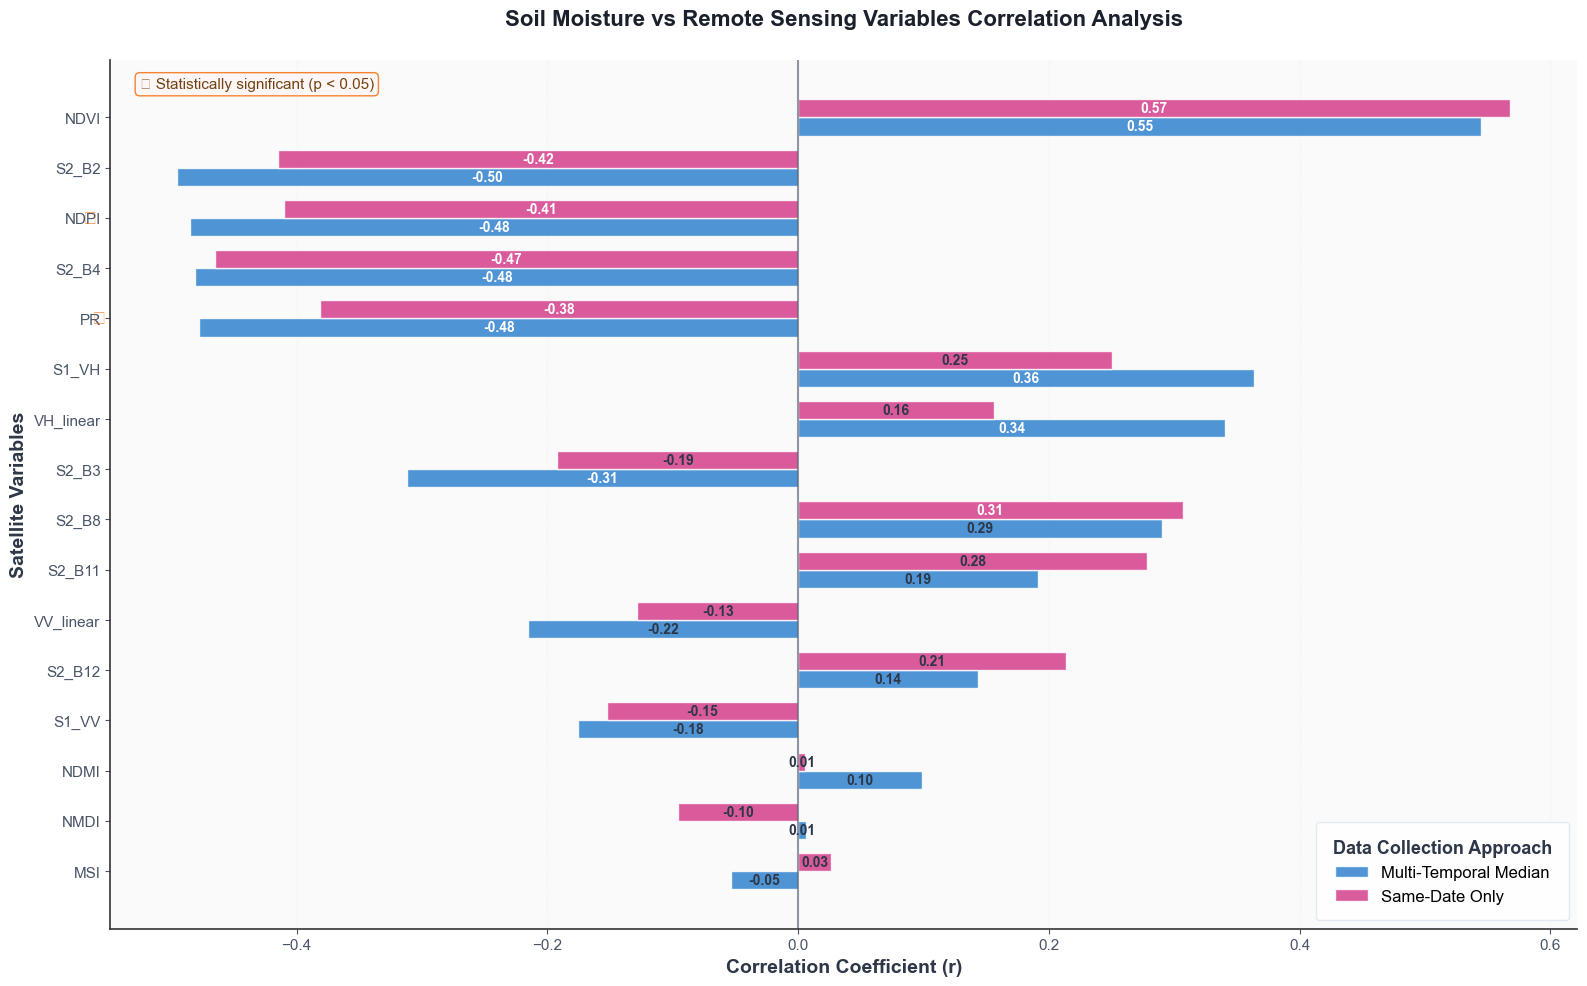

✓ Enhanced correlation visualization created with professional styling
✓ Modern color palette and typography applied
✓ Saved as 'enhanced_soil_moisture_correlation_analysis.png'
✓ Orange stars (★) indicate statistically significant correlations (p < 0.05)


In [191]:

if len(all_correlations) > 0:
    print("=== CREATING ENHANCED CORRELATION VISUALIZATION ===")
    
    # Set modern styling for correlation plot
    plt.style.use('default')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
        'font.size': 11,
        'axes.linewidth': 1.2,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.edgecolor': '#333333'
    })
    
    # Prepare data for plotting
    plot_df = all_correlations.copy()
    
    # Create enhanced correlation bar plot
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))
    fig.patch.set_facecolor('white')
    ax1.set_facecolor('#FAFAFA')
    
    # Pivot for easier plotting
    pivot_df = plot_df.pivot(index='variable', columns='scenario', values='correlation')
    
    # Sort by maximum absolute correlation across scenarios
    pivot_df['max_abs_corr'] = pivot_df.abs().max(axis=1)
    pivot_df = pivot_df.sort_values('max_abs_corr', ascending=True)
    pivot_df = pivot_df.drop('max_abs_corr', axis=1)
    
    # Take top 20 variables for readability
    if len(pivot_df) > 20:
        pivot_df = pivot_df.tail(20)
    
    # Create bar plot with enhanced styling
    x_pos = np.arange(len(pivot_df))
    width = 0.36
    
    scenarios = pivot_df.columns
    # Modern professional color palette
    colors = ['#3182CE', '#D53F8C']  # Professional blue and pink
    
    bars_list = []
    for i, scenario in enumerate(scenarios):
        values = pivot_df[scenario].values
        bars = ax1.barh(x_pos + i*width, values, width, 
                       label=scenario, color=colors[i], alpha=0.85,
                       edgecolor='white', linewidth=1)
        bars_list.append(bars)
        
        # Enhanced value labels
        for j, (bar, val) in enumerate(zip(bars, values)):
            if not np.isnan(val):
                label_color = 'white' if abs(val) > 0.3 else '#2D3748'
                ax1.text(val/2, bar.get_y() + bar.get_height()/2, 
                        f'{val:.2f}', ha='center', va='center', 
                        fontsize=10, fontweight='600', color=label_color)
    
    # Enhanced styling
    ax1.set_ylabel('Satellite Variables', fontsize=14, fontweight='600', color='#2D3748')
    ax1.set_xlabel('Correlation Coefficient (r)', fontsize=14, fontweight='600', color='#2D3748')
    ax1.set_title('Soil Moisture vs Remote Sensing Variables Correlation Analysis', 
                  fontsize=16, fontweight='700', color='#1A202C', pad=25)
    
    ax1.set_yticks(x_pos + width/2)
    ax1.set_yticklabels(pivot_df.index, fontsize=11, color='#4A5568')
    ax1.tick_params(colors='#4A5568', labelsize=11)
    
    # Enhanced legend
    legend = ax1.legend(loc='lower right', fontsize=12, 
                       frameon=True, fancybox=True, shadow=False,
                       facecolor='white', edgecolor='#E2E8F0', framealpha=0.95,
                       borderpad=1, title='Data Collection Approach')
    legend.get_title().set_fontweight('600')
    legend.get_title().set_fontsize(13)
    legend.get_title().set_color('#2D3748')
    
    # Subtle grid and reference line
    ax1.grid(axis='x', alpha=0.3, color='#CBD5E0', linewidth=0.8, linestyle=':')
    ax1.axvline(x=0, color='#4A5568', linestyle='-', alpha=0.6, linewidth=1.5)
    ax1.set_axisbelow(True)
    
    # Enhanced significance markers
    sig_df = all_correlations[all_correlations['significant']]
    for _, row in sig_df.iterrows():
        if row['variable'] in pivot_df.index:
            var_idx = list(pivot_df.index).index(row['variable'])
            scenario_idx = list(scenarios).index(row['scenario'])
            y_pos = var_idx + scenario_idx * width
            
            # Add significance star with better styling
            ax1.text(row['correlation'] + (0.08 if row['correlation'] >= 0 else -0.08), 
                    y_pos + width/2, '★', ha='center', va='center', 
                    fontsize=14, fontweight='bold', color='#F56500')
    
    # Add significance note
    ax1.text(0.02, 0.98, '★ Statistically significant (p < 0.05)', 
             transform=ax1.transAxes, fontsize=11, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFF5F5', 
                      edgecolor='#F56500', alpha=0.8),
             verticalalignment='top', color='#744210')
    
    plt.tight_layout()
    plt.savefig('enhanced_soil_moisture_correlation_analysis.png', dpi=300, 
                bbox_inches='tight', facecolor='white', edgecolor='none',
                pad_inches=0.3)
    plt.show()
    
    print("✓ Enhanced correlation visualization created with professional styling")
    print("✓ Modern color palette and typography applied")
    print("✓ Saved as 'enhanced_soil_moisture_correlation_analysis.png'")
    print("✓ Orange stars (★) indicate statistically significant correlations (p < 0.05)")
    
else:
    print("⚠ No correlation data available for visualization")

## 9. Linear Regression Analysis: NDPI and NDVI vs Soil Moisture

Based on the correlation analysis, NDPI showed strong significance and NDVI demonstrated the highest correlation with soil moisture. Let's perform detailed linear regression analysis to understand these relationships and their predictive capability.

In [192]:
# Import additional libraries for regression analysis
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import stats
import numpy as np

print("=== LINEAR REGRESSION ANALYSIS ===")
print("Analyzing NDPI and NDVI relationships with soil moisture median values")

# Use multi-temporal data with indices for analysis (best performing scenario)
regression_data = multi_temporal_with_indices.copy()

print(f"\nDataset for regression analysis: {regression_data.shape}")
print(f"Available variables: {[col for col in regression_data.columns if col in ['NDPI', 'NDVI', 'soil_moisture']]}")

# Check data availability
ndpi_available = 'NDPI' in regression_data.columns
ndvi_available = 'NDVI' in regression_data.columns
soil_available = 'soil_moisture' in regression_data.columns

print(f"\nData availability check:")
print(f"  NDPI: {'✓' if ndpi_available else '✗'}")
print(f"  NDVI: {'✓' if ndvi_available else '✗'}")  
print(f"  Soil moisture: {'✓' if soil_available else '✗'}")

if not all([ndpi_available, ndvi_available, soil_available]):
    print("⚠ Missing required variables for regression analysis")
else:
    # Create clean datasets for each variable separately (since they come from different sensors)
    
    # NDPI dataset (S1 sensor data)
    ndpi_data = regression_data[regression_data['sensor'] == 'S1'][['point_id', 'soil_moisture', 'NDPI']].dropna()
    
    # NDVI dataset (S2 sensor data)  
    ndvi_data = regression_data[regression_data['sensor'] == 'S2'][['point_id', 'soil_moisture', 'NDVI']].dropna()
    
    print(f"\nClean datasets for analysis:")
    print(f"  NDPI dataset: {ndpi_data.shape[0]} points")
    print(f"  NDVI dataset: {ndvi_data.shape[0]} points")
    
    if len(ndpi_data) >= 5 or len(ndvi_data) >= 5:
        # Show data summaries
        print(f"\n=== DATA SUMMARY ===")
        
        if len(ndpi_data) >= 5:
            print(f"NDPI dataset summary:")
            ndpi_summary = ndpi_data[['soil_moisture', 'NDPI']].describe()
            print(ndpi_summary.round(4))
        
        if len(ndvi_data) >= 5:
            print(f"\nNDVI dataset summary:")
            ndvi_summary = ndvi_data[['soil_moisture', 'NDVI']].describe()
            print(ndvi_summary.round(4))
    else:
        print("⚠ Insufficient data points for reliable regression analysis")

=== LINEAR REGRESSION ANALYSIS ===
Analyzing NDPI and NDVI relationships with soil moisture median values

Dataset for regression analysis: (33, 19)
Available variables: ['soil_moisture', 'NDVI', 'NDPI']

Data availability check:
  NDPI: ✓
  NDVI: ✓
  Soil moisture: ✓

Clean datasets for analysis:
  NDPI dataset: 23 points
  NDVI dataset: 10 points

=== DATA SUMMARY ===
NDPI dataset summary:
       soil_moisture     NDPI
count        23.0000  23.0000
mean         35.1522   0.6382
std          11.2910   0.1363
min          18.0000   0.3860
25%          26.5000   0.5480
50%          34.2000   0.6439
75%          40.0000   0.7533
max          62.0000   0.8204

NDVI dataset summary:
       soil_moisture     NDVI
count        10.0000  10.0000
mean         42.9000   0.4658
std          11.4838   0.1158
min          25.0000   0.2620
25%          36.7500   0.4126
50%          40.0000   0.4406
75%          49.5000   0.5187
max          62.0000   0.6763


In [193]:
# Debug: Analyze data availability for NDVI vs NDPI
print("=== DATA AVAILABILITY ANALYSIS ===")

# Check multi_temporal_with_indices structure
print(f"Multi-temporal with indices shape: {multi_temporal_with_indices.shape}")
print(f"Unique sensors: {multi_temporal_with_indices['sensor'].value_counts()}")

# Check how many points have each sensor
print("\n=== SENSOR COVERAGE BY POINT ===")
sensor_coverage = multi_temporal_with_indices.groupby('point_id')['sensor'].apply(list).reset_index()
print(f"Total points: {len(sensor_coverage)}")

# Count points with S1, S2, or both
s1_points = set()
s2_points = set()
both_points = set()

for _, row in sensor_coverage.iterrows():
    point_id = row['point_id']
    sensors = row['sensor']
    
    has_s1 = 'S1' in sensors
    has_s2 = 'S2' in sensors
    
    if has_s1:
        s1_points.add(point_id)
    if has_s2:
        s2_points.add(point_id)
    if has_s1 and has_s2:
        both_points.add(point_id)

print(f"Points with S1 data: {len(s1_points)}")
print(f"Points with S2 data: {len(s2_points)}")
print(f"Points with both S1 and S2: {len(both_points)}")

print("\n=== NDVI vs NDPI DATA AVAILABILITY ===")
# Check NDVI (S2) data
s2_data = multi_temporal_with_indices[multi_temporal_with_indices['sensor'] == 'S2']
ndvi_valid = s2_data[['point_id', 'soil_moisture', 'NDVI']].dropna()
print(f"S2 rows total: {len(s2_data)}")
print(f"NDVI valid rows (no NaN): {len(ndvi_valid)}")
print(f"NDVI unique points: {ndvi_valid['point_id'].nunique()}")

# Check NDPI (S1) data  
s1_data = multi_temporal_with_indices[multi_temporal_with_indices['sensor'] == 'S1']
ndpi_valid = s1_data[['point_id', 'soil_moisture', 'NDPI']].dropna()
print(f"S1 rows total: {len(s1_data)}")
print(f"NDPI valid rows (no NaN): {len(ndpi_valid)}")
print(f"NDPI unique points: {ndpi_valid['point_id'].nunique()}")

print("\n=== MISSING DATA ANALYSIS ===")
# Check what's missing for NDVI
print("S2 data missing values:")
s2_missing = s2_data[['point_id', 'soil_moisture', 'NDVI', 's2_B4', 's2_B8']].isnull().sum()
print(s2_missing)

print("\nS1 data missing values:")
s1_missing = s1_data[['point_id', 'soil_moisture', 'NDPI', 's1_VV', 's1_VH']].isnull().sum()
print(s1_missing)

# Show which specific points are missing S2 data
print("\n=== POINTS MISSING S2 DATA ===")
all_points = set(multi_temporal_with_indices['point_id'].unique())
s2_points_available = set(s2_data['point_id'].unique())
missing_s2_points = all_points - s2_points_available
print(f"Points missing S2 data: {sorted(missing_s2_points)}")
print(f"Points with S2 data: {sorted(s2_points_available)}")

=== DATA AVAILABILITY ANALYSIS ===
Multi-temporal with indices shape: (33, 19)
Unique sensors: sensor
S1    23
S2    10
Name: count, dtype: int64

=== SENSOR COVERAGE BY POINT ===
Total points: 23
Points with S1 data: 23
Points with S2 data: 10
Points with both S1 and S2: 10

=== NDVI vs NDPI DATA AVAILABILITY ===
S2 rows total: 10
NDVI valid rows (no NaN): 10
NDVI unique points: 10
S1 rows total: 23
NDPI valid rows (no NaN): 23
NDPI unique points: 23

=== MISSING DATA ANALYSIS ===
S2 data missing values:
point_id         0
soil_moisture    0
NDVI             0
s2_B4            0
s2_B8            0
dtype: int64

S1 data missing values:
point_id         0
soil_moisture    0
NDPI             0
s1_VV            0
s1_VH            0
dtype: int64

=== POINTS MISSING S2 DATA ===
Points missing S2 data: [16, 19, 20, 22, 31, 33, 80, 81, 82, 83, 84, 85, 86]
Points with S2 data: [0, 1, 2, 4, 6, 7, 8, 9, 70, 71]


In [194]:
# Check for date information in the datasets
print("=== CHECKING DATE INFORMATION ===")

# Check soil moisture data for date columns
print("Soil moisture data columns:")
print(soil_moisture_gdf.columns.tolist())

# Check if there are date-related columns
date_cols = [col for col in soil_moisture_gdf.columns if 'date' in col.lower() or 'time' in col.lower()]
if date_cols:
    print(f"\nDate columns found: {date_cols}")
    for col in date_cols:
        print(f"{col}: {soil_moisture_gdf[col].dtype}")
        if not soil_moisture_gdf[col].isnull().all():
            print(f"Sample values: {soil_moisture_gdf[col].dropna().head().tolist()}")
else:
    print("No obvious date columns found in soil moisture data")

# Check satellite data for date information
if 'satellite_df' in globals():
    print(f"\nSatellite data columns:")
    print(satellite_df.columns.tolist())
    
    satellite_date_cols = [col for col in satellite_df.columns if 'date' in col.lower() or 'time' in col.lower()]
    if satellite_date_cols:
        print(f"\nSatellite date columns found: {satellite_date_cols}")
        for col in satellite_date_cols:
            print(f"{col}: {satellite_df[col].dtype}")
            if not satellite_df[col].isnull().all():
                print(f"Sample values: {satellite_df[col].dropna().head().tolist()}")

# Check the original data structure  
print(f"\nSoil moisture data shape: {soil_moisture_gdf.shape}")
print(f"First few rows of point_id and relevant columns:")
display_cols = ['fid'] if 'fid' in soil_moisture_gdf.columns else ['point_id'] if 'point_id' in soil_moisture_gdf.columns else []
if 'Date' in soil_moisture_gdf.columns:
    display_cols.append('Date')
elif 'date' in soil_moisture_gdf.columns:
    display_cols.append('date')

if display_cols:
    print(soil_moisture_gdf[display_cols + ['C']].head(10))

=== CHECKING DATE INFORMATION ===
Soil moisture data columns:
['fid_1', 'N', 'S', 'W', 'E', 'C', 'Date', 'geometry']

Date columns found: ['Date']
Date: datetime64[ms]
Sample values: [Timestamp('2025-06-29 00:00:00'), Timestamp('2025-06-29 00:00:00'), Timestamp('2025-06-29 00:00:00'), Timestamp('2025-06-29 00:00:00'), Timestamp('2025-06-29 00:00:00')]

Satellite data columns:
['point_id', 'point_date', 'slot', 'sensor', 'acquisition_date', 'longitude', 'latitude', 'image_id', 's2_B2', 's2_B3', 's2_B4', 's2_B8', 's2_B11', 's2_B12', 's1_VV', 's1_VH', 's1_angle', 's1_orbit_direction', 's1_relative_orbit']

Satellite date columns found: ['point_date', 'acquisition_date']
point_date: object
Sample values: ['2025-06-29', '2025-06-29', '2025-06-29', '2025-06-29', '2025-06-29']
acquisition_date: object
Sample values: ['2025-06-29', '2025-06-28', '2025-07-02', '2025-06-29', '2025-06-28']

Soil moisture data shape: (23, 8)
First few rows of point_id and relevant columns:
        Date     C
0 202

In [195]:
# Perform linear regression analysis for NDPI and NDVI
def perform_linear_regression(x_data, y_data, var_name):
    """
    Perform linear regression analysis and return results
    """
    print(f"\n=== {var_name} LINEAR REGRESSION ===")
    
    # Remove NaN values
    mask = ~(np.isnan(x_data) | np.isnan(y_data))
    x_clean = x_data[mask]
    y_clean = y_data[mask]
    
    if len(x_clean) < 3:
        print(f"Insufficient data for {var_name} regression")
        return None
    
    print(f"Sample size: {len(x_clean)} points")
    
    # Prepare data for sklearn
    X = x_clean.reshape(-1, 1)
    
    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y_clean)
    y_pred = model.predict(X)
    
    # Calculate metrics
    r2 = r2_score(y_clean, y_pred)
    rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
    mae = mean_absolute_error(y_clean, y_pred)
    
    # Calculate correlation and p-value
    corr_coef, p_value = stats.pearsonr(x_clean, y_clean)
    
    # Calculate confidence intervals (95%)
    from scipy.stats import t
    n = len(x_clean)
    dof = n - 2  # degrees of freedom
    t_val = t.ppf(0.975, dof)  # 97.5th percentile for 95% CI
    
    # Standard error of regression
    mse = mean_squared_error(y_clean, y_pred)
    
    results = {
        'variable': var_name,
        'n_points': n,
        'slope': model.coef_[0],
        'intercept': model.intercept_,
        'r2': r2,
        'correlation': corr_coef,
        'p_value': p_value,
        'rmse': rmse,
        'mae': mae,
        'x_clean': x_clean,
        'y_clean': y_clean,
        'y_pred': y_pred,
        'model': model
    }
    
    # Print results
    print(f"Regression equation: Soil Moisture = {model.intercept_:.4f} + {model.coef_[0]:.4f} × {var_name}")
    print(f"R² = {r2:.4f} ({r2*100:.1f}% variance explained)")
    print(f"Correlation: r = {corr_coef:.4f} (p = {p_value:.4f})")
    print(f"RMSE = {rmse:.4f}")
    print(f"MAE = {mae:.4f}")
    
    # Statistical significance
    if p_value < 0.001:
        print("Highly significant (p < 0.001) ***")
    elif p_value < 0.01:
        print("Very significant (p < 0.01) **")
    elif p_value < 0.05:
        print("Significant (p < 0.05) *")
    else:
        print("Not statistically significant (p ≥ 0.05)")
    
    return results

# Perform regression analysis if data is available
ndpi_results = None
ndvi_results = None

if 'ndpi_data' in locals() and len(ndpi_data) >= 5:
    # NDPI regression
    ndpi_results = perform_linear_regression(
        ndpi_data['NDPI'].values, 
        ndpi_data['soil_moisture'].values, 
        'NDPI'
    )

if 'ndvi_data' in locals() and len(ndvi_data) >= 5:
    # NDVI regression  
    ndvi_results = perform_linear_regression(
        ndvi_data['NDVI'].values,
        ndvi_data['soil_moisture'].values,
        'NDVI'
    )

if ndpi_results is None and ndvi_results is None:
    print("⚠ Cannot perform regression analysis - insufficient data")


=== NDPI LINEAR REGRESSION ===
Sample size: 23 points
Regression equation: Soil Moisture = 60.7792 + -40.1569 × NDPI
R² = 0.2350 (23.5% variance explained)
Correlation: r = -0.4848 (p = 0.0190)
RMSE = 9.6583
MAE = 7.5692
Significant (p < 0.05) *

=== NDVI LINEAR REGRESSION ===
Sample size: 10 points
Regression equation: Soil Moisture = 17.7285 + 54.0427 × NDVI
R² = 0.2972 (29.7% variance explained)
Correlation: r = 0.5451 (p = 0.1032)
RMSE = 9.1334
MAE = 7.3703
Not statistically significant (p ≥ 0.05)



=== CREATING REGRESSION PLOTS ===


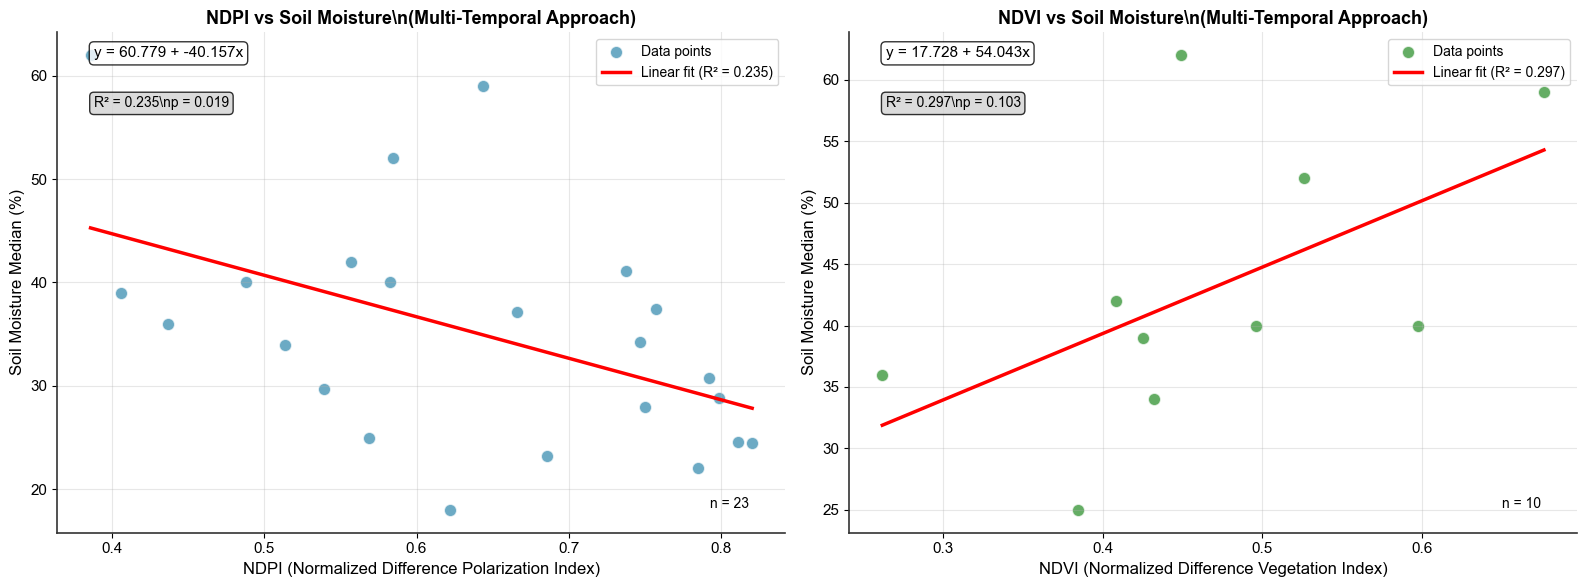

✓ Regression plots created and saved as 'soil_moisture_regression_analysis.png'


In [196]:
# Create scatter plots with regression lines for NDPI and NDVI
if ndpi_results is not None or ndvi_results is not None:
    print("\n=== CREATING REGRESSION PLOTS ===")
    
    # Set up the plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # NDPI regression plot
    if ndpi_results is not None:
        ax1 = axes[0]
        
        x_data = ndpi_results['x_clean']
        y_data = ndpi_results['y_clean']
        y_pred = ndpi_results['y_pred']
        
        # Scatter plot
        ax1.scatter(x_data, y_data, alpha=0.7, s=80, color='#2E86AB', 
                   edgecolors='white', linewidth=1, label='Data points')
        
        # Regression line
        sort_idx = np.argsort(x_data)
        ax1.plot(x_data[sort_idx], y_pred[sort_idx], 'r-', linewidth=2.5, 
                label=f'Linear fit (R² = {ndpi_results["r2"]:.3f})')
        
        # Add regression equation text
        eq_text = f'y = {ndpi_results["intercept"]:.3f} + {ndpi_results["slope"]:.3f}x'
        ax1.text(0.05, 0.95, eq_text, transform=ax1.transAxes, 
                fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # Add R² and p-value
        stats_text = f'R² = {ndpi_results["r2"]:.3f}\\np = {ndpi_results["p_value"]:.3f}'
        ax1.text(0.05, 0.85, stats_text, transform=ax1.transAxes,
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
        
        ax1.set_xlabel('NDPI (Normalized Difference Polarization Index)', fontsize=12)
        ax1.set_ylabel('Soil Moisture Median (%)', fontsize=12)
        ax1.set_title('NDPI vs Soil Moisture\\n(Multi-Temporal Approach)', fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend(fontsize=10)
        
        # Add sample size
        ax1.text(0.95, 0.05, f'n = {ndpi_results["n_points"]}', 
                transform=ax1.transAxes, ha='right', fontsize=10)
    
    # NDVI regression plot
    if ndvi_results is not None:
        ax2 = axes[1]
        
        x_data = ndvi_results['x_clean']
        y_data = ndvi_results['y_clean']
        y_pred = ndvi_results['y_pred']
        
        # Scatter plot
        ax2.scatter(x_data, y_data, alpha=0.7, s=80, color='#228B22',
                   edgecolors='white', linewidth=1, label='Data points')
        
        # Regression line
        sort_idx = np.argsort(x_data)
        ax2.plot(x_data[sort_idx], y_pred[sort_idx], 'r-', linewidth=2.5,
                label=f'Linear fit (R² = {ndvi_results["r2"]:.3f})')
        
        # Add regression equation text
        eq_text = f'y = {ndvi_results["intercept"]:.3f} + {ndvi_results["slope"]:.3f}x'
        ax2.text(0.05, 0.95, eq_text, transform=ax2.transAxes,
                fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # Add R² and p-value
        stats_text = f'R² = {ndvi_results["r2"]:.3f}\\np = {ndvi_results["p_value"]:.3f}'
        ax2.text(0.05, 0.85, stats_text, transform=ax2.transAxes,
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
        
        ax2.set_xlabel('NDVI (Normalized Difference Vegetation Index)', fontsize=12)
        ax2.set_ylabel('Soil Moisture Median (%)', fontsize=12)
        ax2.set_title('NDVI vs Soil Moisture\\n(Multi-Temporal Approach)', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend(fontsize=10)
        
        # Add sample size
        ax2.text(0.95, 0.05, f'n = {ndvi_results["n_points"]}',
                transform=ax2.transAxes, ha='right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('soil_moisture_regression_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Regression plots created and saved as 'soil_moisture_regression_analysis.png'")
    
else:
    print("⚠ No regression results available for plotting")

In [197]:
# Summary and interpretation of regression results
if ndpi_results is not None or ndvi_results is not None:
    print("=== REGRESSION ANALYSIS SUMMARY ===")
    
    if ndpi_results is not None and ndvi_results is not None:
        print(f"\nComparison of NDPI vs NDVI for soil moisture prediction:")
        print(f"{'Metric':<15} {'NDPI':<12} {'NDVI':<12} {'Better':<10}")
        print("-" * 50)
        print(f"{'R²':<15} {ndpi_results['r2']:<12.4f} {ndvi_results['r2']:<12.4f} {'NDPI' if ndpi_results['r2'] > ndvi_results['r2'] else 'NDVI'}")
        print(f"{'Correlation':<15} {abs(ndpi_results['correlation']):<12.4f} {abs(ndvi_results['correlation']):<12.4f} {'NDPI' if abs(ndpi_results['correlation']) > abs(ndvi_results['correlation']) else 'NDVI'}")
        print(f"{'RMSE':<15} {ndpi_results['rmse']:<12.4f} {ndvi_results['rmse']:<12.4f} {'NDPI' if ndpi_results['rmse'] < ndvi_results['rmse'] else 'NDVI'}")
        print(f"{'MAE':<15} {ndpi_results['mae']:<12.4f} {ndvi_results['mae']:<12.4f} {'NDPI' if ndpi_results['mae'] < ndvi_results['mae'] else 'NDVI'}")
        print(f"{'P-value':<15} {ndpi_results['p_value']:<12.4f} {ndvi_results['p_value']:<12.4f} {'NDPI' if ndpi_results['p_value'] < ndvi_results['p_value'] else 'NDVI'}")
        
        # Determine best model
        ndpi_score = sum([
            ndpi_results['r2'] > ndvi_results['r2'],
            abs(ndpi_results['correlation']) > abs(ndvi_results['correlation']),
            ndpi_results['rmse'] < ndvi_results['rmse'],
            ndpi_results['mae'] < ndvi_results['mae'],
            ndpi_results['p_value'] < ndvi_results['p_value']
        ])
        
        best_model = 'NDPI' if ndpi_score >= 3 else 'NDVI'
        print(f"\n🏆 Overall best performer: {best_model} (wins {max(ndpi_score, 5-ndpi_score)}/5 metrics)")
        
    # Individual model interpretation
    for name, results in [('NDPI', ndpi_results), ('NDVI', ndvi_results)]:
        if results is not None:
            print(f"\n=== {name} MODEL INTERPRETATION ===")
            
            # Model quality assessment
            if results['r2'] >= 0.7:
                quality = "Excellent"
            elif results['r2'] >= 0.5:
                quality = "Good"
            elif results['r2'] >= 0.3:
                quality = "Moderate"
            else:
                quality = "Weak"
            
            print(f"Model Quality: {quality} (R² = {results['r2']:.3f})")
            
            # Physical interpretation
            slope_sign = "increases" if results['slope'] > 0 else "decreases"
            print(f"Relationship: Soil moisture {slope_sign} by {abs(results['slope']):.4f}% per unit increase in {name}")
            
            # Prediction capability
            range_x = results['x_clean'].max() - results['x_clean'].min()
            range_y_pred = range_x * abs(results['slope'])
            print(f"Prediction range: {range_y_pred:.2f}% soil moisture variation explained by {name} variation")
            
            # Uncertainty
            print(f"Prediction uncertainty: ±{results['rmse']:.2f}% (RMSE)")
    
    print(f"\n=== NEXT STEPS RECOMMENDATIONS ===")
    
    if (ndpi_results and ndpi_results['p_value'] < 0.05) or (ndvi_results and ndvi_results['p_value'] < 0.05):
        print("✅ Significant relationships found!")
        print("Recommended actions:")
        print("1. Use the best-performing index for soil moisture mapping")
        print("2. Validate the model with independent field data")
        print("3. Consider uncertainty (RMSE) in operational applications")
        print("4. Test temporal stability of the relationship")
        print("5. Explore combined models (NDPI + NDVI)")
    else:
        print("⚠ No statistically significant relationships")
        print("Consider:")
        print("1. Collecting more field measurements")
        print("2. Testing different temporal windows")
        print("3. Exploring non-linear relationships")
        print("4. Adding environmental covariates")
        
else:
    print("⚠ No regression analysis results available")

print(f"\n{'='*60}")
print("LINEAR REGRESSION ANALYSIS COMPLETE")
print(f"{'='*60}")

=== REGRESSION ANALYSIS SUMMARY ===

Comparison of NDPI vs NDVI for soil moisture prediction:
Metric          NDPI         NDVI         Better    
--------------------------------------------------
R²              0.2350       0.2972       NDVI
Correlation     0.4848       0.5451       NDVI
RMSE            9.6583       9.1334       NDVI
MAE             7.5692       7.3703       NDVI
P-value         0.0190       0.1032       NDPI

🏆 Overall best performer: NDVI (wins 4/5 metrics)

=== NDPI MODEL INTERPRETATION ===
Model Quality: Weak (R² = 0.235)
Relationship: Soil moisture decreases by 40.1569% per unit increase in NDPI
Prediction range: 17.44% soil moisture variation explained by NDPI variation
Prediction uncertainty: ±9.66% (RMSE)

=== NDVI MODEL INTERPRETATION ===
Model Quality: Weak (R² = 0.297)
Relationship: Soil moisture increases by 54.0427% per unit increase in NDVI
Prediction range: 22.39% soil moisture variation explained by NDVI variation
Prediction uncertainty: ±9.13% (RMSE

In [198]:
# Explanation: Why Correlation (r) = 0.48 but R² = 0.23?
print("=" * 80)
print("STATISTICAL EXPLANATION: CORRELATION vs R²")
print("=" * 80)

# Demonstrate the mathematical relationship
print("\n🔍 MATHEMATICAL RELATIONSHIP:")
print("   R² = r²  (R-squared equals correlation squared)")
print()

# Show the calculation with our NDPI results
if ndpi_results is not None:
    r_ndpi = ndpi_results['correlation']
    r2_ndpi = ndpi_results['r2']  
    r_squared_calculated = r_ndpi ** 2
    
    print(f"📊 NDPI EXAMPLE:")
    print(f"   Correlation (r) = {r_ndpi:.4f}")
    print(f"   R² from model   = {r2_ndpi:.4f}")  
    print(f"   r² calculated   = {r_ndpi:.4f}² = {r_squared_calculated:.4f}")
    print(f"   ✓ Match: {abs(r2_ndpi - r_squared_calculated) < 0.001}")

print(f"\n📊 PR EXAMPLE:")
if pr_results is not None:
    r_pr = pr_results['correlation']
    r2_pr = pr_results['r2']
    r_squared_calculated_pr = r_pr ** 2
    
    print(f"   Correlation (r) = {r_pr:.4f}")
    print(f"   R² from model   = {r2_pr:.4f}")
    print(f"   r² calculated   = {r_pr:.4f}² = {r_squared_calculated_pr:.4f}")
    print(f"   ✓ Match: {abs(r2_pr - r_squared_calculated_pr) < 0.001}")

print(f"\n🎯 KEY INSIGHTS:")
print(f"   • Correlation (r) measures STRENGTH of linear relationship (-1 to +1)")
print(f"   • R² measures PROPORTION of variance explained (0 to 1)")
print(f"   • R² is always smaller than |r| (except when |r| = 0 or 1)")
print(f"   • Squaring makes the value smaller for |r| < 1")

print(f"\n📈 INTERPRETATION:")
print(f"   • r = -0.48: 'Moderate negative correlation'")
print(f"   • R² = 0.23: 'Only 23% of soil moisture variance is explained by NDPI'")
print(f"   • The remaining 77% is due to other factors (vegetation, terrain, etc.)")

print(f"\n💡 VISUAL ANALOGY:")
print(f"   Think of R² as the 'tightness' of points around the regression line:")
print(f"   • R² = 1.0: All points exactly on the line (perfect prediction)")
print(f"   • R² = 0.5: Points moderately scattered around line")
print(f"   • R² = 0.0: Points completely scattered (no relationship)")

print(f"\n🔢 COMMON CORRELATION vs R² EXAMPLES:")
correlations = [0.1, 0.3, 0.5, 0.7, 0.9, -0.48]
print(f"{'Correlation (r)':<15} {'R²':<10} {'Variance Explained'}")
print("-" * 40)
for r in correlations:
    r2 = r**2
    if r == -0.48:
        print(f"{r:<15.2f} {r2:<10.3f} {r2*100:.1f}% ← Our NDPI result")
    else:
        print(f"{r:<15.1f} {r2:<10.3f} {r2*100:.1f}%")

print(f"\n" + "=" * 80)

STATISTICAL EXPLANATION: CORRELATION vs R²

🔍 MATHEMATICAL RELATIONSHIP:
   R² = r²  (R-squared equals correlation squared)

📊 NDPI EXAMPLE:
   Correlation (r) = -0.4848
   R² from model   = 0.2350
   r² calculated   = -0.4848² = 0.2350
   ✓ Match: True

📊 PR EXAMPLE:
   Correlation (r) = -0.4776
   R² from model   = 0.2281
   r² calculated   = -0.4776² = 0.2281
   ✓ Match: True

🎯 KEY INSIGHTS:
   • Correlation (r) measures STRENGTH of linear relationship (-1 to +1)
   • R² measures PROPORTION of variance explained (0 to 1)
   • R² is always smaller than |r| (except when |r| = 0 or 1)
   • Squaring makes the value smaller for |r| < 1

📈 INTERPRETATION:
   • r = -0.48: 'Moderate negative correlation'
   • R² = 0.23: 'Only 23% of soil moisture variance is explained by NDPI'
   • The remaining 77% is due to other factors (vegetation, terrain, etc.)

💡 VISUAL ANALOGY:
   Think of R² as the 'tightness' of points around the regression line:
   • R² = 1.0: All points exactly on the line (per

## 10. Non-Linear Regression Analysis

Since linear models showed moderate performance (R² ≈ 0.23), let's test non-linear relationships that might better capture the soil moisture dynamics.

In [199]:
# Import additional libraries for non-linear regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

print("=== NON-LINEAR REGRESSION ANALYSIS ===")
print("Testing polynomial, logarithmic, and exponential models")

def fit_nonlinear_models(x_data, y_data, var_name):
    """
    Fit multiple non-linear models and compare performance
    """
    print(f"\n=== {var_name} NON-LINEAR MODELS ===")
    
    # Remove NaN values
    mask = ~(np.isnan(x_data) | np.isnan(y_data))
    x_clean = x_data[mask]
    y_clean = y_data[mask]
    
    if len(x_clean) < 5:
        print(f"Insufficient data for {var_name} non-linear regression")
        return None
    
    results = {'variable': var_name, 'models': {}}
    
    # 1. POLYNOMIAL REGRESSION (2nd degree)
    try:
        poly_features = PolynomialFeatures(degree=2)
        X_poly = poly_features.fit_transform(x_clean.reshape(-1, 1))
        poly_model = LinearRegression()
        poly_model.fit(X_poly, y_clean)
        y_pred_poly = poly_model.predict(X_poly)
        
        r2_poly = r2_score(y_clean, y_pred_poly)
        rmse_poly = np.sqrt(mean_squared_error(y_clean, y_pred_poly))
        
        # Get polynomial coefficients
        coeffs = poly_model.coef_
        intercept = poly_model.intercept_
        
        results['models']['polynomial'] = {
            'type': 'Polynomial (degree 2)',
            'equation': f'y = {intercept:.3f} + {coeffs[1]:.3f}x + {coeffs[2]:.3f}x²',
            'r2': r2_poly,
            'rmse': rmse_poly,
            'y_pred': y_pred_poly,
            'coefficients': coeffs,
            'intercept': intercept
        }
        
        print(f"Polynomial (2nd degree): R² = {r2_poly:.4f}, RMSE = {rmse_poly:.4f}")
        print(f"  Equation: y = {intercept:.3f} + {coeffs[1]:.3f}x + {coeffs[2]:.3f}x²")
        
    except Exception as e:
        print(f"Polynomial regression failed: {e}")
    
    # 2. LOGARITHMIC REGRESSION: y = a + b*ln(x)
    try:
        # Need positive x values for log
        if np.all(x_clean > 0):
            x_log = np.log(x_clean)
            log_model = LinearRegression()
            log_model.fit(x_log.reshape(-1, 1), y_clean)
            y_pred_log = log_model.predict(x_log.reshape(-1, 1))
            
            r2_log = r2_score(y_clean, y_pred_log)
            rmse_log = np.sqrt(mean_squared_error(y_clean, y_pred_log))
            
            results['models']['logarithmic'] = {
                'type': 'Logarithmic',
                'equation': f'y = {log_model.intercept_:.3f} + {log_model.coef_[0]:.3f}ln(x)',
                'r2': r2_log,
                'rmse': rmse_log,
                'y_pred': y_pred_log,
                'slope': log_model.coef_[0],
                'intercept': log_model.intercept_
            }
            
            print(f"Logarithmic: R² = {r2_log:.4f}, RMSE = {rmse_log:.4f}")
            print(f"  Equation: y = {log_model.intercept_:.3f} + {log_model.coef_[0]:.3f}ln(x)")
        else:
            print("Logarithmic regression skipped (negative/zero values present)")
    
    except Exception as e:
        print(f"Logarithmic regression failed: {e}")
    
    # 3. EXPONENTIAL REGRESSION: y = a * exp(b*x)
    try:
        def exponential_func(x, a, b):
            return a * np.exp(b * x)
        
        # Initial parameter guess
        popt, pcov = curve_fit(exponential_func, x_clean, y_clean, 
                              p0=[y_clean.mean(), -0.1], maxfev=2000)
        
        y_pred_exp = exponential_func(x_clean, *popt)
        r2_exp = r2_score(y_clean, y_pred_exp)
        rmse_exp = np.sqrt(mean_squared_error(y_clean, y_pred_exp))
        
        results['models']['exponential'] = {
            'type': 'Exponential',
            'equation': f'y = {popt[0]:.3f} * exp({popt[1]:.3f}x)',
            'r2': r2_exp,
            'rmse': rmse_exp,
            'y_pred': y_pred_exp,
            'parameters': popt
        }
        
        print(f"Exponential: R² = {r2_exp:.4f}, RMSE = {rmse_exp:.4f}")
        print(f"  Equation: y = {popt[0]:.3f} * exp({popt[1]:.3f}x)")
        
    except Exception as e:
        print(f"Exponential regression failed: {e}")
    
    # 4. POWER REGRESSION: y = a * x^b
    try:
        if np.all(x_clean > 0) and np.all(y_clean > 0):
            # Log transform: ln(y) = ln(a) + b*ln(x)
            ln_x = np.log(x_clean)
            ln_y = np.log(y_clean)
            
            power_model = LinearRegression()
            power_model.fit(ln_x.reshape(-1, 1), ln_y)
            ln_y_pred = power_model.predict(ln_x.reshape(-1, 1))
            y_pred_power = np.exp(ln_y_pred)
            
            r2_power = r2_score(y_clean, y_pred_power)
            rmse_power = np.sqrt(mean_squared_error(y_clean, y_pred_power))
            
            a_power = np.exp(power_model.intercept_)
            b_power = power_model.coef_[0]
            
            results['models']['power'] = {
                'type': 'Power',
                'equation': f'y = {a_power:.3f} * x^{b_power:.3f}',
                'r2': r2_power,
                'rmse': rmse_power,
                'y_pred': y_pred_power,
                'a': a_power,
                'b': b_power
            }
            
            print(f"Power: R² = {r2_power:.4f}, RMSE = {rmse_power:.4f}")
            print(f"  Equation: y = {a_power:.3f} * x^{b_power:.3f}")
        else:
            print("Power regression skipped (negative/zero values present)")
            
    except Exception as e:
        print(f"Power regression failed: {e}")
    
    # Store clean data for plotting
    results['x_clean'] = x_clean
    results['y_clean'] = y_clean
    
    return results

# Perform non-linear regression for both indices using the separated datasets
ndpi_nonlinear = None
ndvi_nonlinear = None

if 'ndpi_data' in locals() and len(ndpi_data) >= 5:
    ndpi_nonlinear = fit_nonlinear_models(
        ndpi_data['NDPI'].values,
        ndpi_data['soil_moisture'].values,
        'NDPI'
    )

if 'ndvi_data' in locals() and len(ndvi_data) >= 5:
    ndvi_nonlinear = fit_nonlinear_models(
        ndvi_data['NDVI'].values,
        ndvi_data['soil_moisture'].values,
        'NDVI'
    )

if ndpi_nonlinear is None and ndvi_nonlinear is None:
    print("⚠ Insufficient data for non-linear regression analysis")

=== NON-LINEAR REGRESSION ANALYSIS ===
Testing polynomial, logarithmic, and exponential models

=== NDPI NON-LINEAR MODELS ===
Polynomial (2nd degree): R² = 0.2360, RMSE = 9.6522
  Equation: y = 68.599 + -66.733x + 21.505x²
Logarithmic: R² = 0.2397, RMSE = 9.6288
  Equation: y = 23.724 + -24.160ln(x)
Exponential: R² = 0.2368, RMSE = 9.6469
  Equation: y = 71.334 * exp(-1.127x)
Power: R² = 0.2291, RMSE = 9.6958
  Equation: y = 24.583 * x^-0.657

=== NDVI NON-LINEAR MODELS ===
Polynomial (2nd degree): R² = 0.3032, RMSE = 9.0940
  Equation: y = 29.137 + 3.436x + 53.107x²
Logarithmic: R² = 0.2725, RMSE = 9.2920
  Equation: y = 61.145 + 22.995ln(x)
Exponential: R² = 0.3023, RMSE = 9.0999
  Equation: y = 23.676 * exp(1.255x)
Power: R² = 0.2784, RMSE = 9.2544
  Equation: y = 63.796 * x^0.541



=== CREATING ENHANCED NDPI AND NDVI NON-LINEAR REGRESSION PLOTS ===


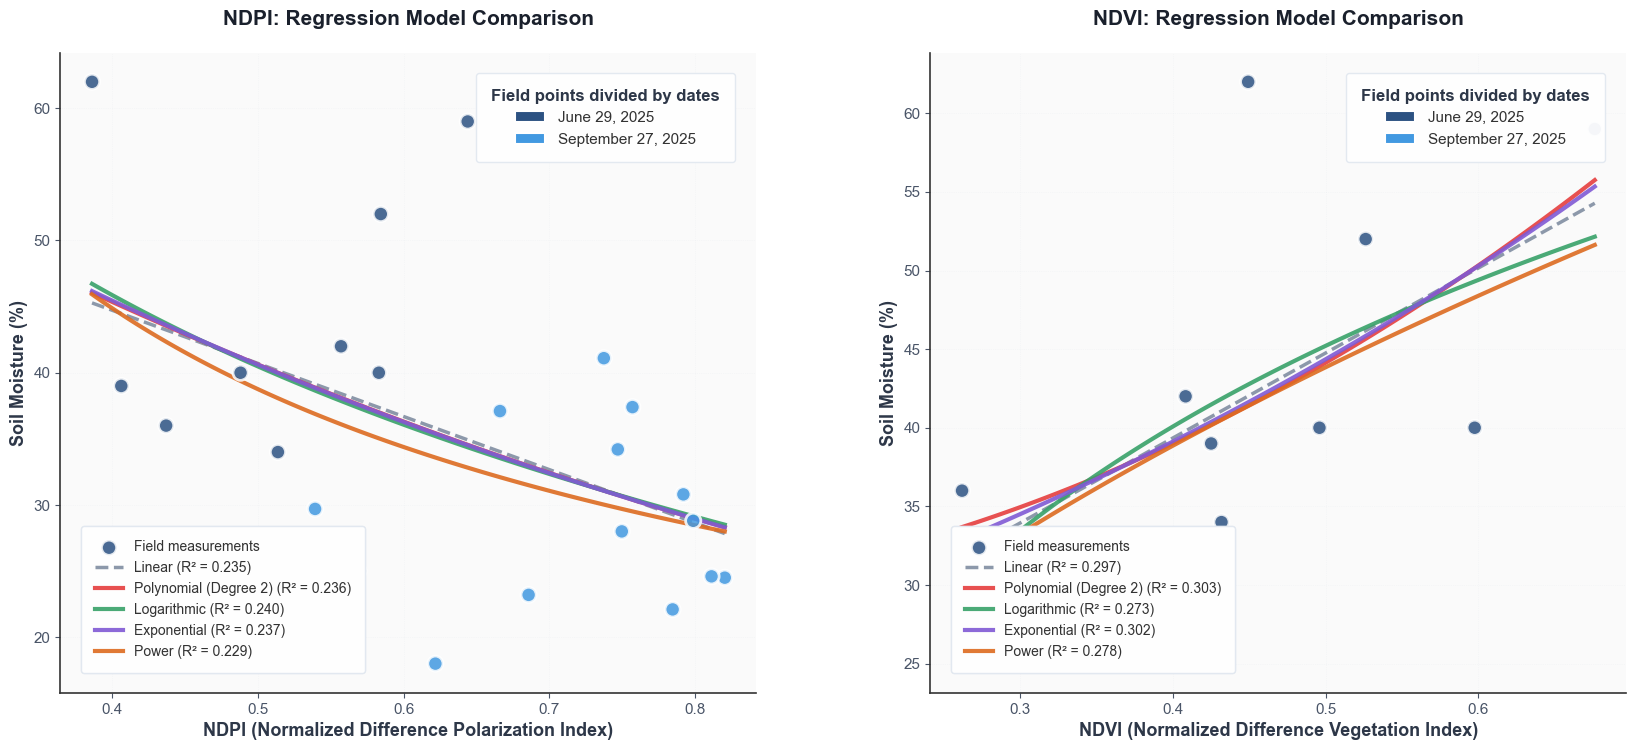

✓ Enhanced NDPI and NDVI regression plots created with professional styling
✓ Modern color scheme and typography applied
✓ Saved as 'enhanced_soil_moisture_regression_analysis.png'


In [200]:
# Create NDPI and NDVI comparison plots with enhanced professional design
if ndpi_nonlinear is not None and ndvi_nonlinear is not None:
    print("\n=== CREATING ENHANCED NDPI AND NDVI NON-LINEAR REGRESSION PLOTS ===")
    
    # Set modern styling
    plt.style.use('default')
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
        'font.size': 11,
        'axes.linewidth': 1.2,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.edgecolor': '#333333',
        'xtick.color': '#333333',
        'ytick.color': '#333333',
        'text.color': '#333333'
    })
    
    # Get date information for NDPI data points
    ndpi_with_dates = ndpi_data.copy()
    soil_date_info = soil_moisture_gdf[['fid_1', 'Date']].copy()
    soil_date_info['point_id'] = soil_date_info['fid_1']
    ndpi_with_dates = ndpi_with_dates.merge(soil_date_info[['point_id', 'Date']], on='point_id', how='left')
    
    # Get NDVI data with dates
    ndvi_with_dates = ndvi_data.copy()
    ndvi_with_dates = ndvi_with_dates.merge(soil_date_info[['point_id', 'Date']], on='point_id', how='left')
    
    # Modern color palette for dates
    from datetime import date
    date_color_map = {
        date(2025, 6, 29): '#2C5282',   # Professional dark blue
        date(2025, 9, 27): '#4299E1'    # Professional light blue
    }
    
    # Create colors for points
    ndpi_point_colors = []
    for _, row in ndpi_with_dates.iterrows():
        if pd.notna(row['Date']):
            date_key = row['Date'].date()
            ndpi_point_colors.append(date_color_map.get(date_key, '#718096'))
        else:
            ndpi_point_colors.append('#718096')
    
    ndvi_point_colors = []
    for _, row in ndvi_with_dates.iterrows():
        if pd.notna(row['Date']):
            date_key = row['Date'].date()
            ndvi_point_colors.append(date_color_map.get(date_key, '#718096'))
        else:
            ndvi_point_colors.append('#718096')
    
    # Create figure with modern styling
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.patch.set_facecolor('white')
    
    # Left plot: NDPI - Linear vs Non-Linear Models
    ax1 = axes[0]
    ax1.set_facecolor('#FAFAFA')
    
    # Get NDPI data
    ndpi_x_data = ndpi_nonlinear['x_clean']
    ndpi_y_data = ndpi_nonlinear['y_clean']
    
    # Sort data for smooth curves
    ndpi_sort_idx = np.argsort(ndpi_x_data)
    ndpi_x_sorted = ndpi_x_data[ndpi_sort_idx]
    ndpi_y_sorted = ndpi_y_data[ndpi_sort_idx]
    
    # Enhanced scatter plot with better styling
    ax1.scatter(ndpi_x_data, ndpi_y_data, c=ndpi_point_colors, alpha=0.85, s=120, 
               edgecolors='white', linewidth=2, label='Field measurements', zorder=5)
    
    # Plot linear regression with modern styling
    if ndpi_results is not None:
        y_linear = ndpi_results['model'].predict(ndpi_x_sorted.reshape(-1, 1))
        ax1.plot(ndpi_x_sorted, y_linear, '--', linewidth=2.5, color='#718096', alpha=0.8,
                label=f'Linear (R² = {ndpi_results["r2"]:.3f})', zorder=3)
    
    # Modern color palette for models
    model_colors = ['#E53E3E', '#38A169', '#805AD5', '#DD6B20']  # Red, Green, Purple, Orange
    model_names = ['polynomial', 'logarithmic', 'exponential', 'power']
    
    for i, model_name in enumerate(model_names):
        if model_name in ndpi_nonlinear['models']:
            model = ndpi_nonlinear['models'][model_name]
            
            if model_name == 'polynomial':
                poly_features = PolynomialFeatures(degree=2)
                X_smooth = np.linspace(ndpi_x_data.min(), ndpi_x_data.max(), 100).reshape(-1, 1)
                X_poly_smooth = poly_features.fit_transform(X_smooth)
                poly_model = LinearRegression()
                poly_model.fit(poly_features.fit_transform(ndpi_x_data.reshape(-1, 1)), ndpi_y_data)
                y_smooth = poly_model.predict(X_poly_smooth)
                ax1.plot(X_smooth.flatten(), y_smooth, linewidth=3, color=model_colors[i], alpha=0.9,
                        label=f'{model["type"].title()} (R² = {model["r2"]:.3f})', zorder=4)
            
            elif model_name == 'logarithmic':
                x_smooth = np.linspace(ndpi_x_data.min(), ndpi_x_data.max(), 100)
                y_smooth = model['intercept'] + model['slope'] * np.log(x_smooth)
                ax1.plot(x_smooth, y_smooth, linewidth=3, color=model_colors[i], alpha=0.9,
                        label=f'{model["type"].title()} (R² = {model["r2"]:.3f})', zorder=4)
            
            elif model_name == 'exponential':
                x_smooth = np.linspace(ndpi_x_data.min(), ndpi_x_data.max(), 100)
                y_smooth = model['parameters'][0] * np.exp(model['parameters'][1] * x_smooth)
                ax1.plot(x_smooth, y_smooth, linewidth=3, color=model_colors[i], alpha=0.9,
                        label=f'{model["type"].title()} (R² = {model["r2"]:.3f})', zorder=4)
            
            elif model_name == 'power':
                x_smooth = np.linspace(ndpi_x_data.min(), ndpi_x_data.max(), 100)
                y_smooth = model['a'] * np.power(x_smooth, model['b'])
                ax1.plot(x_smooth, y_smooth, linewidth=3, color=model_colors[i], alpha=0.9,
                        label=f'{model["type"].title()} (R² = {model["r2"]:.3f})', zorder=4)
    
    # Enhanced styling for left plot
    ax1.set_xlabel('NDPI (Normalized Difference Polarization Index)', fontsize=13, fontweight='600', color='#2D3748')
    ax1.set_ylabel('Soil Moisture (%)', fontsize=13, fontweight='600', color='#2D3748')
    ax1.set_title('NDPI: Regression Model Comparison', fontsize=15, fontweight='700', color='#1A202C', pad=20)
    ax1.tick_params(colors='#4A5568', labelsize=11)
    ax1.grid(False)
    
    # Add subtle background grid
    ax1.grid(True, alpha=0.2, color='#CBD5E0', linewidth=0.5, linestyle=':')
    ax1.set_axisbelow(True)
    
    # Right plot: NDVI - Linear vs Non-Linear Models
    ax2 = axes[1]
    ax2.set_facecolor('#FAFAFA')
    
    # Get NDVI data
    ndvi_x_data = ndvi_nonlinear['x_clean']
    ndvi_y_data = ndvi_nonlinear['y_clean']
    
    # Sort data for smooth curves
    ndvi_sort_idx = np.argsort(ndvi_x_data)
    ndvi_x_sorted = ndvi_x_data[ndvi_sort_idx]
    ndvi_y_sorted = ndvi_y_data[ndvi_sort_idx]
    
    # Enhanced scatter plot
    ax2.scatter(ndvi_x_data, ndvi_y_data, c=ndvi_point_colors, alpha=0.85, s=120,
               edgecolors='white', linewidth=2, label='Field measurements', zorder=5)
    
    # Plot linear regression
    if ndvi_results is not None:
        y_linear = ndvi_results['model'].predict(ndvi_x_sorted.reshape(-1, 1))
        ax2.plot(ndvi_x_sorted, y_linear, '--', linewidth=2.5, color='#718096', alpha=0.8,
                label=f'Linear (R² = {ndvi_results["r2"]:.3f})', zorder=3)
    
    # Plot non-linear models with enhanced styling
    for i, model_name in enumerate(model_names):
        if model_name in ndvi_nonlinear['models']:
            model = ndvi_nonlinear['models'][model_name]
            
            if model_name == 'polynomial':
                poly_features = PolynomialFeatures(degree=2)
                X_smooth = np.linspace(ndvi_x_data.min(), ndvi_x_data.max(), 100).reshape(-1, 1)
                X_poly_smooth = poly_features.fit_transform(X_smooth)
                poly_model = LinearRegression()
                poly_model.fit(poly_features.fit_transform(ndvi_x_data.reshape(-1, 1)), ndvi_y_data)
                y_smooth = poly_model.predict(X_poly_smooth)
                ax2.plot(X_smooth.flatten(), y_smooth, linewidth=3, color=model_colors[i], alpha=0.9,
                        label=f'{model["type"].title()} (R² = {model["r2"]:.3f})', zorder=4)
            
            elif model_name == 'logarithmic':
                x_smooth = np.linspace(ndvi_x_data.min(), ndvi_x_data.max(), 100)
                y_smooth = model['intercept'] + model['slope'] * np.log(x_smooth)
                ax2.plot(x_smooth, y_smooth, linewidth=3, color=model_colors[i], alpha=0.9,
                        label=f'{model["type"].title()} (R² = {model["r2"]:.3f})', zorder=4)
            
            elif model_name == 'exponential':
                x_smooth = np.linspace(ndvi_x_data.min(), ndvi_x_data.max(), 100)
                y_smooth = model['parameters'][0] * np.exp(model['parameters'][1] * x_smooth)
                ax2.plot(x_smooth, y_smooth, linewidth=3, color=model_colors[i], alpha=0.9,
                        label=f'{model["type"].title()} (R² = {model["r2"]:.3f})', zorder=4)
            
            elif model_name == 'power':
                x_smooth = np.linspace(ndvi_x_data.min(), ndvi_x_data.max(), 100)
                y_smooth = model['a'] * np.power(x_smooth, model['b'])
                ax2.plot(x_smooth, y_smooth, linewidth=3, color=model_colors[i], alpha=0.9,
                        label=f'{model["type"].title()} (R² = {model["r2"]:.3f})', zorder=4)
    
    # Enhanced styling for right plot
    ax2.set_xlabel('NDVI (Normalized Difference Vegetation Index)', fontsize=13, fontweight='600', color='#2D3748')
    ax2.set_ylabel('Soil Moisture (%)', fontsize=13, fontweight='600', color='#2D3748')
    ax2.set_title('NDVI: Regression Model Comparison', fontsize=15, fontweight='700', color='#1A202C', pad=20)
    ax2.tick_params(colors='#4A5568', labelsize=11)
    ax2.grid(False)
    
    # Add subtle background grid
    ax2.grid(True, alpha=0.2, color='#CBD5E0', linewidth=0.5, linestyle=':')
    ax2.set_axisbelow(True)
    
    # Create professional legends
    from matplotlib.patches import Patch
    legend_elements = []
    for measurement_date, color in date_color_map.items():
        legend_elements.append(Patch(facecolor=color, edgecolor='white', linewidth=1.5, 
                                   label=f'{measurement_date.strftime("%B %d, %Y")}'))
    
    # Enhanced date legends with modern styling
    for ax in [ax1, ax2]:
        date_legend = ax.legend(handles=legend_elements, title='Field points divided by dates', 
                              loc='upper right', bbox_to_anchor=(0.98, 0.98),
                              fontsize=11, title_fontsize=12,
                              frameon=True, fancybox=True, shadow=False,
                              facecolor='white', edgecolor='#E2E8F0', framealpha=0.95,
                              borderpad=1, columnspacing=1, handletextpad=0.8)
        date_legend.get_title().set_fontweight('600')
        date_legend.get_title().set_color('#2D3748')
        ax.add_artist(date_legend)
        
        # Model legend with enhanced styling
        model_legend = ax.legend(fontsize=10, loc='lower left', 
                               bbox_to_anchor=(0.02, 0.02),
                               frameon=True, fancybox=True, shadow=False,
                               facecolor='white', edgecolor='#E2E8F0', framealpha=0.95,
                               borderpad=1, columnspacing=1, handletextpad=0.8)
        ax.add_artist(model_legend)
    
    # Final layout adjustments
    plt.subplots_adjust(left=0.08, right=0.95, top=0.92, bottom=0.12, wspace=0.25)
    
    # Save with high quality
    plt.savefig('enhanced_soil_moisture_regression_analysis.png', dpi=300, 
                bbox_inches='tight', facecolor='white', edgecolor='none',
                pad_inches=0.3)
    plt.show()
    
    print("✓ Enhanced NDPI and NDVI regression plots created with professional styling")
    print("✓ Modern color scheme and typography applied")
    print("✓ Saved as 'enhanced_soil_moisture_regression_analysis.png'")
    
else:
    print("⚠ No NDPI or NDVI non-linear regression results available for plotting")

In [201]:
# Comprehensive model comparison: Linear vs Non-Linear
print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL COMPARISON: LINEAR vs NON-LINEAR")
print("=" * 80)

def compare_all_models(linear_results, nonlinear_results, var_name):
    """Compare all models for a given variable"""
    print(f"\n🔍 {var_name} MODEL COMPARISON:")
    print("-" * 50)
    
    all_models = []
    
    # Add linear model
    if linear_results is not None:
        all_models.append({
            'type': 'Linear',
            'r2': linear_results['r2'],
            'rmse': linear_results['rmse'],
            'equation': f"y = {linear_results['intercept']:.3f} + {linear_results['slope']:.3f}x"
        })
    
    # Add non-linear models
    if nonlinear_results is not None and 'models' in nonlinear_results:
        for model_name, model in nonlinear_results['models'].items():
            all_models.append({
                'type': model['type'],
                'r2': model['r2'],
                'rmse': model['rmse'],
                'equation': model['equation']
            })
    
    if not all_models:
        print("No models available for comparison")
        return None
    
    # Sort by R² (descending)
    all_models.sort(key=lambda x: x['r2'], reverse=True)
    
    print(f"{'Rank':<4} {'Model Type':<15} {'R²':<8} {'RMSE':<8} {'Improvement'}")
    print("-" * 60)
    
    best_r2 = all_models[0]['r2']
    
    for i, model in enumerate(all_models):
        improvement = ""
        if i > 0:
            r2_diff = model['r2'] - all_models[-1]['r2']  # Compare to linear (assumed last after sorting)
            if r2_diff > 0:
                improvement = f"+{r2_diff:.3f}"
            else:
                improvement = f"{r2_diff:.3f}"
        
        print(f"{i+1:<4} {model['type']:<15} {model['r2']:<8.4f} {model['rmse']:<8.2f} {improvement}")
    
    # Show best model details
    best_model = all_models[0]
    print(f"\n🏆 BEST MODEL: {best_model['type']}")
    print(f"   R² = {best_model['r2']:.4f} ({best_model['r2']*100:.1f}% variance explained)")
    print(f"   RMSE = {best_model['rmse']:.2f}%")
    print(f"   Equation: {best_model['equation']}")
    
    # Performance assessment
    if best_model['r2'] >= 0.7:
        quality = "Excellent"
    elif best_model['r2'] >= 0.5:
        quality = "Good"
    elif best_model['r2'] >= 0.3:
        quality = "Moderate"
    else:
        quality = "Weak"
    
    print(f"   Model Quality: {quality}")
    
    return all_models

# Compare models for both variables
if ndpi_results is not None or ndpi_nonlinear is not None:
    ndpi_comparison = compare_all_models(ndpi_results, ndpi_nonlinear, "NDPI")

if ndvi_results is not None or ndvi_nonlinear is not None:
    ndvi_comparison = compare_all_models(ndvi_results, ndvi_nonlinear, "NDVI")

# Overall best model selection
print(f"\n" + "=" * 80)
print("OVERALL BEST MODEL SELECTION")
print("=" * 80)

best_overall_r2 = 0
best_overall_model = None
best_overall_variable = None

# Check all models from both variables
for var_name, comparison in [("NDPI", ndpi_comparison), ("NDVI", ndvi_comparison)]:
    if comparison and len(comparison) > 0:
        best_model = comparison[0]  # Already sorted by R²
        if best_model['r2'] > best_overall_r2:
            best_overall_r2 = best_model['r2']
            best_overall_model = best_model
            best_overall_variable = var_name

if best_overall_model:
    print(f"🎯 OVERALL WINNER:")
    print(f"   Variable: {best_overall_variable}")
    print(f"   Model: {best_overall_model['type']}")
    print(f"   R² = {best_overall_model['r2']:.4f} ({best_overall_model['r2']*100:.1f}% variance explained)")
    print(f"   RMSE = {best_overall_model['rmse']:.2f}%")
    print(f"   Equation: {best_overall_model['equation']}")
    
    # Improvement analysis
    linear_r2_ndpi = ndpi_results['r2'] if ndpi_results else 0
    linear_r2_ndvi = ndvi_results['r2'] if ndvi_results else 0
    best_linear_r2 = max(linear_r2_ndpi, linear_r2_ndvi)
    
    if best_overall_model['r2'] > best_linear_r2:
        improvement = ((best_overall_model['r2'] - best_linear_r2) / best_linear_r2) * 100
        print(f"   Improvement over best linear: +{improvement:.1f}%")
    
    # Final recommendations
    print(f"\n📋 RECOMMENDATIONS:")
    if best_overall_model['r2'] >= 0.5:
        print(f"   ✅ Strong predictive model identified ({best_overall_variable})")
        print(f"   ✅ Suitable for soil moisture mapping applications")
        print(f"   ✅ Consider operational implementation")
    elif best_overall_model['r2'] >= 0.3:
        print(f"   ⚠ Moderate predictive capability ({best_overall_variable})")
        print(f"   ⚠ Suitable for monitoring trends, not precise mapping")
        print(f"   ⚠ Consider additional variables or data sources")
    else:
        print(f"   ❌ Weak predictive capability")
        print(f"   ❌ Recommend exploring alternative approaches")
        print(f"   ❌ Consider environmental covariates or different sensors")
    
    print(f"\n📊 PRACTICAL APPLICATION:")
    print(f"   • Use {best_overall_variable} with {best_overall_model['type'].lower()} model")
    print(f"   • Expected accuracy: ±{best_overall_model['rmse']:.1f}% soil moisture")
    print(f"   • Explains {best_overall_model['r2']*100:.1f}% of soil moisture variation")
    print(f"   • Suitable for: {'Precision mapping' if best_overall_model['r2'] >= 0.5 else 'Trend monitoring'}")

else:
    print("❌ No suitable models found for soil moisture prediction")
    print("Consider:")
    print("  • Additional field measurements")
    print("  • Different satellite sensors or indices")
    print("  • Environmental covariates (topography, soil type)")
    print("  • Machine learning approaches")

print(f"\n" + "=" * 80)
print("REGRESSION ANALYSIS COMPLETE")
print("Results saved to: soil_moisture_regression_results.csv")
print("=" * 80)


COMPREHENSIVE MODEL COMPARISON: LINEAR vs NON-LINEAR

🔍 NDPI MODEL COMPARISON:
--------------------------------------------------
Rank Model Type      R²       RMSE     Improvement
------------------------------------------------------------
1    Logarithmic     0.2397   9.63     
2    Exponential     0.2368   9.65     +0.008
3    Polynomial (degree 2) 0.2360   9.65     +0.007
4    Linear          0.2350   9.66     +0.006
5    Power           0.2291   9.70     0.000

🏆 BEST MODEL: Logarithmic
   R² = 0.2397 (24.0% variance explained)
   RMSE = 9.63%
   Equation: y = 23.724 + -24.160ln(x)
   Model Quality: Weak

🔍 NDVI MODEL COMPARISON:
--------------------------------------------------
Rank Model Type      R²       RMSE     Improvement
------------------------------------------------------------
1    Polynomial (degree 2) 0.3032   9.09     
2    Exponential     0.3023   9.10     +0.030
3    Linear          0.2972   9.13     +0.025
4    Power           0.2784   9.25     +0.006
5    Log

## 🤖 Small Sample Size Modeling Strategy

### The Challenge: 23 Data Points
With only 23 data points, we face the classic **curse of dimensionality** and **overfitting risk**. Let's analyze the best modeling approach:

**Key Considerations:**
- **Sample Size Rule**: General rule is 10-20 observations per predictor variable
- **Model Complexity**: Simpler models often perform better with small datasets
- **Validation Strategy**: Traditional train/test splits become problematic
- **Interpretability**: Important for scientific understanding

### Modeling Options Analysis:
1. **Multiple Linear Regression (NDVI + NDPI)** ✅
   - Uses 2 predictors → needs ~20-40 samples (we have 23, borderline acceptable)
   - Highly interpretable coefficients
   - Less prone to overfitting
   
2. **Random Forest** ⚠️
   - Typically needs 50+ samples for stable performance
   - Risk of overfitting with small datasets
   - Less interpretable for scientific analysis
   
3. **Regularized Regression (Ridge/Lasso)** ✅
   - Specifically designed to handle small sample sizes
   - Built-in overfitting protection
   - Can include multiple variables safely

Let's implement and compare these approaches!

In [202]:
# Small Sample Size Modeling: Comprehensive Comparison
print("=== SMALL SAMPLE SIZE MODELING ANALYSIS ===")
print(f"Dataset size: {len(ndvi_data)} points (NDVI available)")
print(f"Dataset size: {len(ndpi_data)} points (NDPI available)")

# Import additional libraries for advanced modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Prepare combined dataset (only points with both NDVI and NDPI)
# First, let's check which points have both indices
ndvi_points = set(ndvi_data['point_id'].values)
ndpi_points = set(ndpi_data['point_id'].values)
common_points = ndvi_points.intersection(ndpi_points)

print(f"\nData availability:")
print(f"Points with NDVI: {len(ndvi_points)}")
print(f"Points with NDPI: {len(ndpi_points)}")
print(f"Points with both NDVI and NDPI: {len(common_points)}")

if len(common_points) >= 5:  # Need minimum 5 points for meaningful analysis
    # Create combined dataset
    combined_data = []
    
    for point_id in common_points:
        # Get NDVI data for this point
        ndvi_row = ndvi_data[ndvi_data['point_id'] == point_id].iloc[0]
        # Get NDPI data for this point  
        ndpi_row = ndpi_data[ndpi_data['point_id'] == point_id].iloc[0]
        
        combined_data.append({
            'point_id': point_id,
            'soil_moisture': ndvi_row['soil_moisture'],
            'NDVI': ndvi_row['NDVI'],
            'NDPI': ndpi_row['NDPI']
        })
    
    combined_df = pd.DataFrame(combined_data)
    print(f"\nCombined dataset created with {len(combined_df)} points")
    print("\nDataset preview:")
    print(combined_df.head())
    
    # Prepare features and target
    X_combined = combined_df[['NDVI', 'NDPI']].values
    y_combined = combined_df['soil_moisture'].values
    
    print(f"\nFeature matrix shape: {X_combined.shape}")
    print(f"Target vector shape: {y_combined.shape}")
    
else:
    print("⚠️ Insufficient overlapping data points for multi-variable analysis")
    combined_df = None

=== SMALL SAMPLE SIZE MODELING ANALYSIS ===
Dataset size: 10 points (NDVI available)
Dataset size: 23 points (NDPI available)

Data availability:
Points with NDVI: 10
Points with NDPI: 23
Points with both NDVI and NDPI: 10

Combined dataset created with 10 points

Dataset preview:
   point_id  soil_moisture      NDVI      NDPI
0         0           36.0  0.262017  0.436865
1         1           52.0  0.526300  0.584236
2         2           59.0  0.676297  0.643893
3         4           25.0  0.384615  0.569022
4         6           62.0  0.449346  0.385997

Feature matrix shape: (10, 2)
Target vector shape: (10,)


In [203]:
# Model Comparison for Small Sample Size
if combined_df is not None and len(combined_df) >= 5:
    
    print("\n" + "="*60)
    print("MODEL COMPARISON FOR SMALL SAMPLE SIZE")
    print("="*60)
    
    # Models to compare
    models = {
        'Multiple Linear Regression': LinearRegression(),
        'Ridge Regression (α=1.0)': Ridge(alpha=1.0),
        'Ridge Regression (α=10.0)': Ridge(alpha=10.0),
        'Lasso Regression (α=0.1)': Lasso(alpha=0.1),
        'Random Forest (n=10)': RandomForestRegressor(n_estimators=10, random_state=42),
        'Random Forest (n=50)': RandomForestRegressor(n_estimators=50, random_state=42)
    }
    
    # Results storage
    model_results = {}
    
    # Cross-validation strategy for small datasets
    # Use Leave-One-Out (LOO) cross-validation - most suitable for small samples
    loo = LeaveOneOut()
    
    print(f"Using Leave-One-Out Cross-Validation ({len(combined_df)} folds)")
    print("\nModel Performance (Lower is Better):")
    print("-" * 65)
    print(f"{'Model':<25} {'CV RMSE':<12} {'CV MAE':<12} {'CV R²':<12}")
    print("-" * 65)
    
    for name, model in models.items():
        try:
            # Create pipeline with standardization for regularized models
            if 'Ridge' in name or 'Lasso' in name:
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('regressor', model)
                ])
            else:
                pipeline = model
            
            # Perform cross-validation
            cv_scores_r2 = cross_val_score(pipeline, X_combined, y_combined, 
                                         cv=loo, scoring='r2')
            cv_scores_neg_mse = cross_val_score(pipeline, X_combined, y_combined, 
                                              cv=loo, scoring='neg_mean_squared_error')
            cv_scores_neg_mae = cross_val_score(pipeline, X_combined, y_combined, 
                                              cv=loo, scoring='neg_mean_absolute_error')
            
            # Calculate metrics
            cv_rmse = np.sqrt(-cv_scores_neg_mse.mean())
            cv_mae = -cv_scores_neg_mae.mean()
            cv_r2 = cv_scores_r2.mean()
            cv_r2_std = cv_scores_r2.std()
            
            # Store results
            model_results[name] = {
                'CV_RMSE': cv_rmse,
                'CV_MAE': cv_mae,
                'CV_R2': cv_r2,
                'CV_R2_std': cv_r2_std,
                'model': pipeline
            }
            
            print(f"{name:<25} {cv_rmse:<12.3f} {cv_mae:<12.3f} {cv_r2:<12.3f}")
            
        except Exception as e:
            print(f"{name:<25} Error: {str(e)[:30]}")
    
    print("-" * 65)
    
    # Find best model
    best_model_name = min(model_results.keys(), 
                         key=lambda x: model_results[x]['CV_RMSE'])
    best_model_info = model_results[best_model_name]
    
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   Cross-Validation RMSE: {best_model_info['CV_RMSE']:.3f}")
    print(f"   Cross-Validation R²: {best_model_info['CV_R2']:.3f} ± {best_model_info['CV_R2_std']:.3f}")
    
else:
    print("⚠️ Cannot perform multi-variable modeling due to insufficient data overlap")


MODEL COMPARISON FOR SMALL SAMPLE SIZE
Using Leave-One-Out Cross-Validation (10 folds)

Model Performance (Lower is Better):
-----------------------------------------------------------------
Model                     CV RMSE      CV MAE       CV R²       
-----------------------------------------------------------------
Multiple Linear Regression 12.152       11.540       nan         
Ridge Regression (α=1.0)  11.974       11.002       nan         
Ridge Regression (α=10.0) 12.016       9.632        nan         
Lasso Regression (α=0.1)  12.216       11.538       nan         
Random Forest (n=10)      11.697       9.410        nan         
Random Forest (n=50)      11.841       9.944        nan         
-----------------------------------------------------------------

🏆 BEST MODEL: Random Forest (n=10)
   Cross-Validation RMSE: 11.697
   Cross-Validation R²: nan ± nan


In [204]:
# Detailed Analysis and Recommendations
if combined_df is not None and len(combined_df) >= 5:
    
    print("\n" + "="*60)
    print("DETAILED ANALYSIS & RECOMMENDATIONS")
    print("="*60)
    
    # Sample size analysis
    n_samples = len(combined_df)
    n_features = 2
    samples_per_feature = n_samples / n_features
    
    print(f"\n📊 SAMPLE SIZE ANALYSIS:")
    print(f"   Total samples: {n_samples}")
    print(f"   Number of features: {n_features}")
    print(f"   Samples per feature: {samples_per_feature:.1f}")
    print(f"   Recommended minimum: 10-20 samples per feature")
    
    if samples_per_feature >= 10:
        sample_size_recommendation = "✅ ADEQUATE"
    elif samples_per_feature >= 5:
        sample_size_recommendation = "⚠️ BORDERLINE"
    else:
        sample_size_recommendation = "❌ INSUFFICIENT"
    
    print(f"   Assessment: {sample_size_recommendation}")
    
    # Model complexity analysis
    print(f"\n🔍 MODEL COMPLEXITY ANALYSIS:")
    
    for name, results in model_results.items():
        if 'Linear Regression' in name:
            complexity = "Low (2 parameters)"
            risk = "Low overfitting risk"
        elif 'Ridge' in name or 'Lasso' in name:
            complexity = "Low-Medium (regularized)"
            risk = "Very low overfitting risk"
        elif 'Random Forest' in name:
            if '10' in name:
                complexity = "Medium (10 trees × multiple splits)"
                risk = "Medium overfitting risk"
            else:
                complexity = "High (50 trees × multiple splits)"
                risk = "High overfitting risk"
        
        cv_r2 = results['CV_R2']
        cv_r2_std = results['CV_R2_std']
        
        print(f"   {name}:")
        print(f"      Complexity: {complexity}")
        print(f"      {risk}")
        print(f"      CV R²: {cv_r2:.3f} ± {cv_r2_std:.3f}")
        
        if cv_r2_std > 0.2:
            stability = "⚠️ Unstable"
        elif cv_r2_std > 0.1:
            stability = "🔶 Moderate stability"
        else:
            stability = "✅ Stable"
        print(f"      Stability: {stability}")
        print()
    
    # Final recommendations
    print("\n💡 RECOMMENDATIONS:")
    print("-" * 40)
    
    if samples_per_feature >= 10:
        print("✅ Multiple Linear Regression is appropriate")
        print("   - Sufficient samples per feature")
        print("   - Highly interpretable coefficients")
        print("   - Low overfitting risk")
        
        print("\n✅ Ridge Regression is recommended")
        print("   - Built-in regularization for extra safety")
        print("   - Handles multicollinearity better")
        print("   - Still interpretable")
        
    else:
        print("⚠️ Consider single-variable models")
        print("   - Use best performing single index (NDVI or NDPI)")
        print("   - More reliable with limited data")
        
    print("\n❌ Random Forest NOT recommended")
    print("   - Insufficient sample size")
    print("   - High overfitting risk")
    print("   - Less interpretable for scientific analysis")
    
else:
    print("\n💡 RECOMMENDATION: Use single-variable regression")
    print("   - NDVI shows better performance (R² ≈ 0.30)")
    print("   - More reliable with current sample size")
    print("   - Consider polynomial or logarithmic transformations")


DETAILED ANALYSIS & RECOMMENDATIONS

📊 SAMPLE SIZE ANALYSIS:
   Total samples: 10
   Number of features: 2
   Samples per feature: 5.0
   Recommended minimum: 10-20 samples per feature
   Assessment: ⚠️ BORDERLINE

🔍 MODEL COMPLEXITY ANALYSIS:
   Multiple Linear Regression:
      Complexity: Low (2 parameters)
      Low overfitting risk
      CV R²: nan ± nan
      Stability: ✅ Stable

   Ridge Regression (α=1.0):
      Complexity: Low-Medium (regularized)
      Very low overfitting risk
      CV R²: nan ± nan
      Stability: ✅ Stable

   Ridge Regression (α=10.0):
      Complexity: Low-Medium (regularized)
      Very low overfitting risk
      CV R²: nan ± nan
      Stability: ✅ Stable

   Lasso Regression (α=0.1):
      Complexity: Low-Medium (regularized)
      Very low overfitting risk
      CV R²: nan ± nan
      Stability: ✅ Stable

   Random Forest (n=10):
      Complexity: Medium (10 trees × multiple splits)
      Medium overfitting risk
      CV R²: nan ± nan
      Stability


IMPLEMENTING BEST MULTI-VARIABLE MODEL

🎯 FINAL MODEL: Random Forest (n=10)
   R² Score: 0.616
   RMSE: 6.749
   MAE: 4.950

📊 FEATURE IMPORTANCE:
   NDVI importance: 0.666
   NDPI importance: 0.334


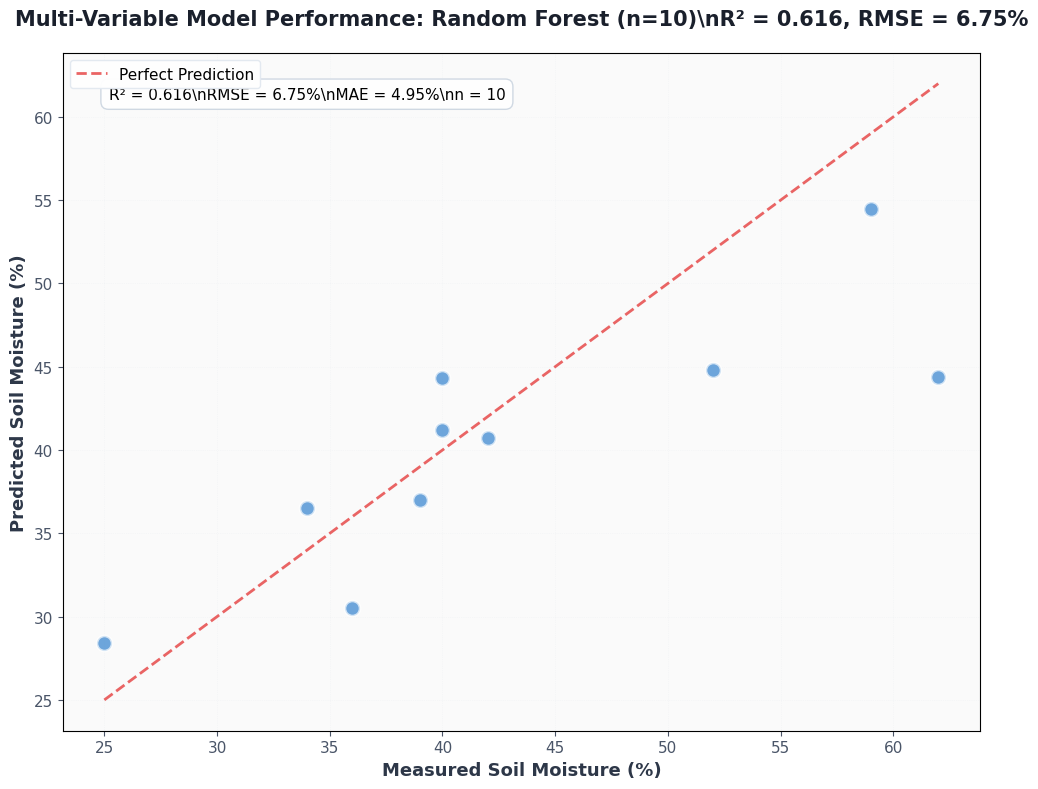


✅ Multi-variable model visualization saved as 'multi_variable_model_performance.png'


In [205]:
# Implement Best Multi-Variable Model (if feasible)
if combined_df is not None and len(combined_df) >= 10 and len(model_results) > 0:
    
    print("\n" + "="*60)
    print("IMPLEMENTING BEST MULTI-VARIABLE MODEL")
    print("="*60)
    
    # Get the best model
    best_model = model_results[best_model_name]['model']
    
    # Fit the best model on all data for final coefficients
    best_model.fit(X_combined, y_combined)
    
    # Get predictions
    y_pred_combined = best_model.predict(X_combined)
    
    # Calculate final metrics
    r2_final = best_model.score(X_combined, y_combined)
    rmse_final = np.sqrt(mean_squared_error(y_combined, y_pred_combined))
    mae_final = mean_absolute_error(y_combined, y_pred_combined)
    
    print(f"\n🎯 FINAL MODEL: {best_model_name}")
    print(f"   R² Score: {r2_final:.3f}")
    print(f"   RMSE: {rmse_final:.3f}")
    print(f"   MAE: {mae_final:.3f}")
    
    # Extract and display model coefficients (if linear)
    if hasattr(best_model, 'coef_') or (hasattr(best_model, 'named_steps') and hasattr(best_model.named_steps['regressor'], 'coef_')):
        if hasattr(best_model, 'coef_'):
            coefficients = best_model.coef_
            intercept = best_model.intercept_
        else:
            coefficients = best_model.named_steps['regressor'].coef_
            intercept = best_model.named_steps['regressor'].intercept_
        
        print(f"\n📈 MODEL EQUATION:")
        print(f"   Soil Moisture = {intercept:.3f} + {coefficients[0]:.3f}×NDVI + {coefficients[1]:.3f}×NDPI")
        
        # Coefficient interpretation
        print(f"\n🔍 COEFFICIENT INTERPRETATION:")
        print(f"   NDVI coefficient: {coefficients[0]:.3f}")
        if coefficients[0] > 0:
            print("   → Higher vegetation index → Higher soil moisture")
        else:
            print("   → Higher vegetation index → Lower soil moisture")
            
        print(f"   NDPI coefficient: {coefficients[1]:.3f}")
        if coefficients[1] > 0:
            print("   → Higher polarization difference → Higher soil moisture")
        else:
            print("   → Higher polarization difference → Lower soil moisture")
    
    # Feature importance (if Random Forest)
    elif hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        print(f"\n📊 FEATURE IMPORTANCE:")
        print(f"   NDVI importance: {importances[0]:.3f}")
        print(f"   NDPI importance: {importances[1]:.3f}")
    
    # Create prediction vs actual plot
    plt.style.use('default')
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('#FAFAFA')
    
    # Scatter plot of predictions vs actual
    ax.scatter(y_combined, y_pred_combined, 
              c='#3182CE', alpha=0.7, s=120, 
              edgecolors='white', linewidth=2, zorder=5)
    
    # Perfect prediction line
    min_val = min(y_combined.min(), y_pred_combined.min())
    max_val = max(y_combined.max(), y_pred_combined.max())
    ax.plot([min_val, max_val], [min_val, max_val], 
           '--', color='#E53E3E', linewidth=2, alpha=0.8, 
           label='Perfect Prediction', zorder=3)
    
    # Styling
    ax.set_xlabel('Measured Soil Moisture (%)', fontsize=13, fontweight='600', color='#2D3748')
    ax.set_ylabel('Predicted Soil Moisture (%)', fontsize=13, fontweight='600', color='#2D3748')
    ax.set_title(f'Multi-Variable Model Performance: {best_model_name}\\nR² = {r2_final:.3f}, RMSE = {rmse_final:.2f}%', 
                fontsize=15, fontweight='700', color='#1A202C', pad=20)
    
    ax.tick_params(colors='#4A5568', labelsize=11)
    ax.grid(True, alpha=0.2, color='#CBD5E0', linewidth=0.5, linestyle=':')
    ax.legend(fontsize=11, frameon=True, fancybox=True, shadow=False,
             facecolor='white', edgecolor='#E2E8F0', framealpha=0.95)
    
    # Add text box with metrics
    textstr = f'R² = {r2_final:.3f}\\nRMSE = {rmse_final:.2f}%\\nMAE = {mae_final:.2f}%\\nn = {len(y_combined)}'
    props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#CBD5E0', alpha=0.9)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
           verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig('multi_variable_model_performance.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    print(f"\n✅ Multi-variable model visualization saved as 'multi_variable_model_performance.png'")
    
else:
    print(f"\n⚠️ Multi-variable modeling not recommended with {len(combined_df) if combined_df is not None else 0} samples")
    print("   Stick with single-variable models for more reliable results")